In [2]:
pip install prophet

     |████████████████████████████████| 8.8 MB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 93 kB 3.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [834]:
%matplotlib inline
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import prophet

import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

warnings.filterwarnings('ignore')

In [1552]:
def MASE(Actual, Predicted):
    n = len(Actual)
    
    mae = mean_absolute_error(Actual, Predicted)

    # Calculate the denominator
    denominator = (1 / (n - 1)) * np.sum(np.abs(Actual[1:] - Actual[:-1]))

    # Avoid division by zero or small denominators
    if denominator > 1e-6:
        mase = mae / denominator
    else:
        mase = np.inf

    return mase

# data prep

In [9]:
east = pd.read_csv('data/east_daily.csv', index_col=0, parse_dates=[0])
midwest = pd.read_csv('data/midwest_daily.csv', index_col=0, parse_dates=[0]) 
south = pd.read_csv('data/south_daily.csv', index_col=0, parse_dates=[0]) 
west = pd.read_csv('data/west_daily.csv', index_col=0, parse_dates=[0]) 

In [12]:
east = east.sort_index()
midwest = midwest.sort_index()
south = south.sort_index()
west = west.sort_index()

In [313]:
train_size = int(len(east) * 0.9)

east_train, east_test = east[0:train_size], east[train_size:]
print(east_train.shape, east_test.shape)

midwest_train, midwest_test = midwest[0:train_size], midwest[train_size:]
print(midwest_train.shape, midwest_test.shape)

south_train, south_test = south[0:train_size], south[train_size:]
print(south_train.shape, south_test.shape)

west_train, west_test = west[0:train_size], west[train_size:]
print(west_train.shape, west_test.shape)

(1022, 1) (114, 1)
(1022, 1) (114, 1)
(1022, 1) (114, 1)
(1022, 1) (114, 1)


In [202]:
east_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(east_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

midwest_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

south_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(south_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

west_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(west_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

TEST SET  TRAINING SET
date                              
2020-02-12       NaN           0.0
2020-02-13       NaN           0.0
2020-02-14       NaN           0.0
2020-02-15       NaN           0.0
2020-02-16       NaN           0.0
...              ...           ...
2023-03-19       0.0           NaN
2023-03-20      37.0           NaN
2023-03-21      33.0           NaN
2023-03-22     184.0           NaN
2023-03-23      89.0           NaN

[1136 rows x 2 columns]

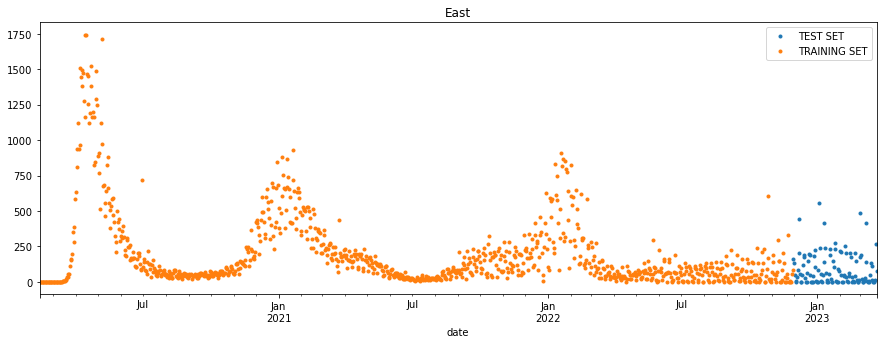

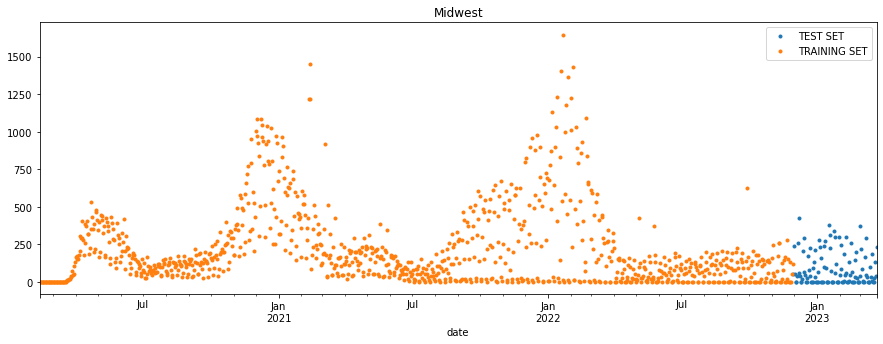

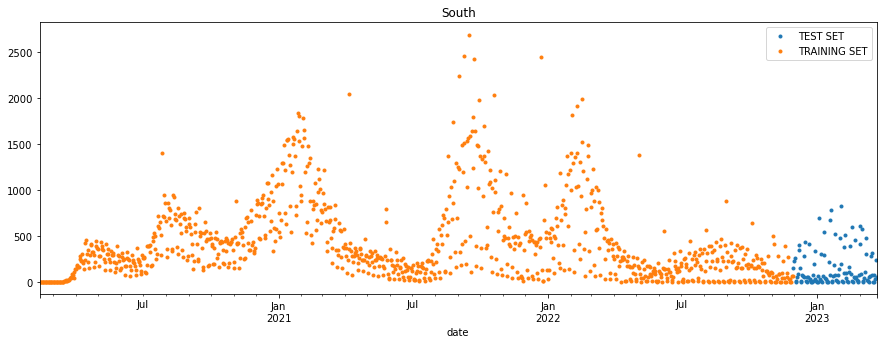

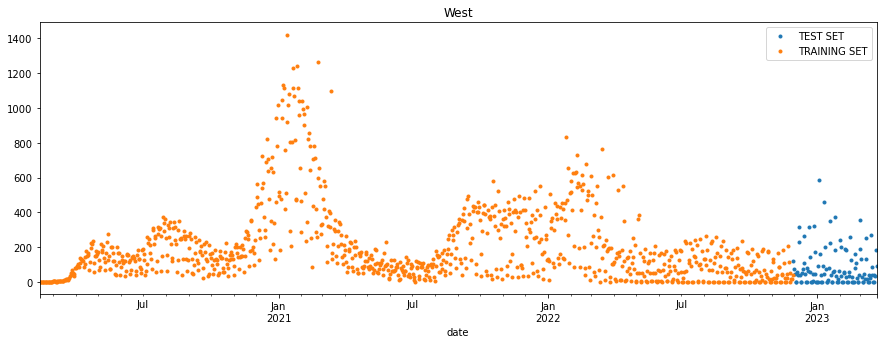

In [1610]:
_ = east_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(east_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='East', style='.')

_ = midwest_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Midwest', style='.')

_ = south_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(south_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='South', style='.')

_ = west_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(west_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='West', style='.')

# Univariate Prophet

### east

In [314]:
east_model = prophet.Prophet().fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))



03:05:56 - cmdstanpy - INFO - Chain [1] start processing
03:05:56 - cmdstanpy - INFO - Chain [1] done processing


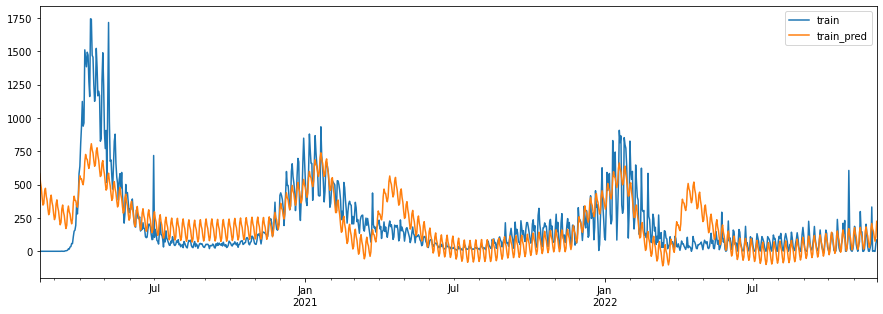

Training Set Metrics:
MAE: 126.31169182411163
MASE: 1.9373017072874457


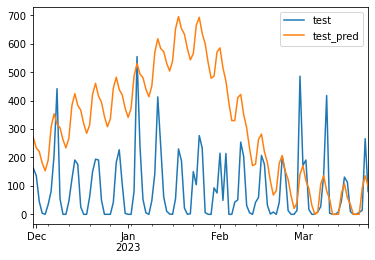

Testing Set Metrics:
MAE: 242.5279650823465
MASE: 2.7383753051863664


In [1273]:
train_pred=east_model.predict(east_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([east_train,train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(east_train.values, train_pred['yhat'].values)
mase_train = MASE(east_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=east_model.predict(east_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
east_test[east_test<0] = 0
pd.concat([east_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(east_test.values, test_pred['yhat'].values)
mase_test = MASE(east_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

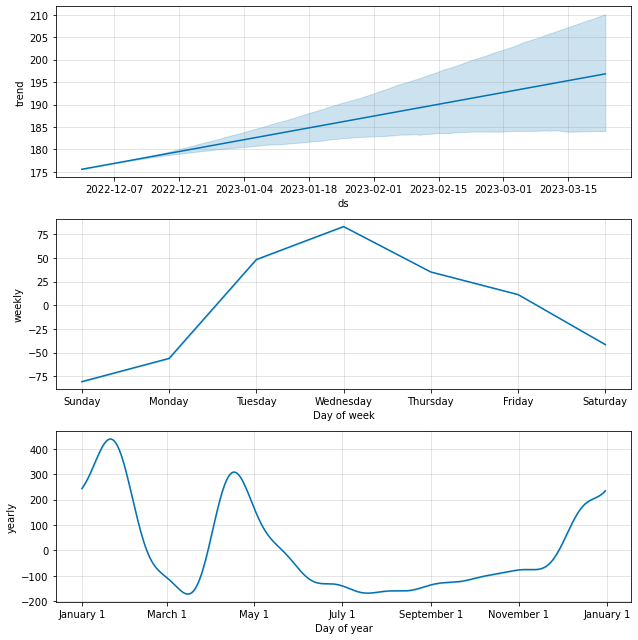

In [316]:
test_pred = test_pred.reset_index()

fig = east_model.plot_components(test_pred)
plt.show()

In [1602]:
east_model2 = prophet.Prophet(
    changepoint_prior_scale=0.02, # make trend less flexible (default is .05)
    yearly_seasonality = False # get rid of yearly seasonality
)

east_model2.add_seasonality(name='weekly', period=7, fourier_order = 3) # decrease weekly (default is 3)
east_model2.add_seasonality(name='monthly', period=30.5, fourier_order = 3) 

east_model2.fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

22:40:49 - cmdstanpy - INFO - Chain [1] start processing
22:40:49 - cmdstanpy - INFO - Chain [1] done processing


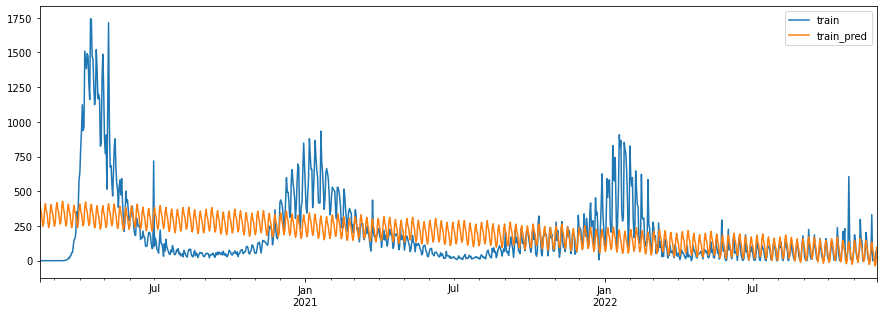

Training Set Metrics:
MAE: 159.9973754629822
MASE: 2.453954849069459


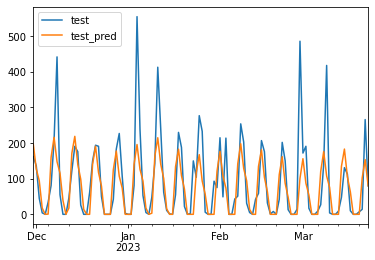

Testing Set Metrics:
MAE: 49.56568016320526
MASE: 0.559644470268005


In [1603]:
train_pred=east_model2.predict(east_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([east_train,train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(east_train.values, train_pred['yhat'].values)
mase_train = MASE(east_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=east_model2.predict(east_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
test_pred = test_pred * 1.5
east_test[east_test<0] = 0
pd.concat([east_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(east_test.values, test_pred['yhat'].values)
mase_test = MASE(east_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1597]:
east_model2 = prophet.Prophet(
    changepoint_prior_scale=0.02, # make trend less flexible (default is .05)
    yearly_seasonality = False # get rid of yearly seasonality
)

east_model2.add_seasonality(name='weekly', period=7, fourier_order=1) # decrease weekly (default is 3)
east_model2.add_seasonality(name='monthly', period=30.5, fourier_order=1) 

east_model2.fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

22:39:26 - cmdstanpy - INFO - Chain [1] start processing
22:39:27 - cmdstanpy - INFO - Chain [1] done processing


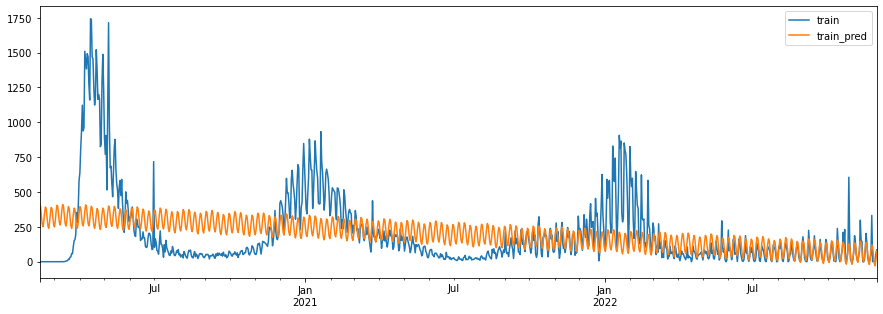

Training Set Metrics:
MAE: 159.75020932923275
MASE: 2.450163946058175


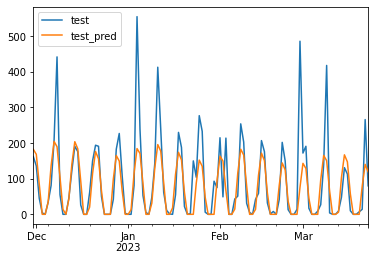

Testing Set Metrics:
MAE: 42.21994142283548
MASE: 0.47670397489812244


In [1598]:
train_pred=east_model2.predict(east_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([east_train,train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(east_train.values, train_pred['yhat'].values)
mase_train = MASE(east_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=east_model2.predict(east_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
test_pred = test_pred * 1.5
east_test[east_test<0] = 0
pd.concat([east_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(east_test.values, test_pred['yhat'].values)
mase_test = MASE(east_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

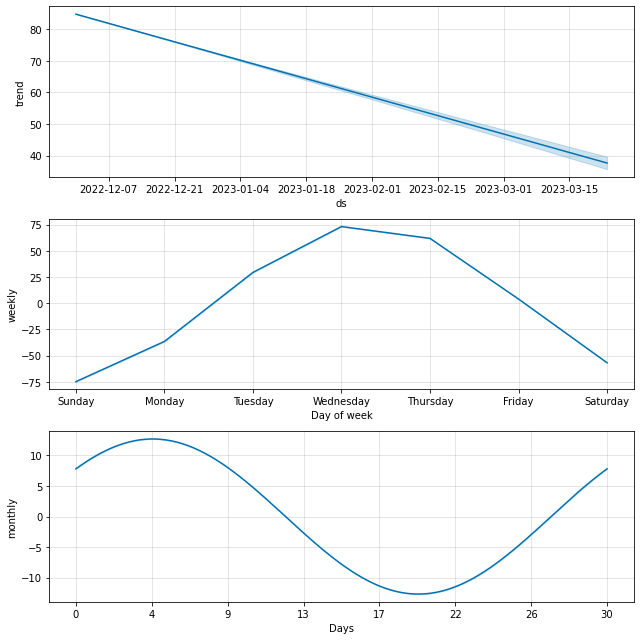

In [1599]:
test_pred = test_pred.reset_index()

fig = east_model2.plot_components(test_pred)
plt.show()

### midwest

In [120]:
midwest_model = prophet.Prophet().fit(midwest_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))


02:24:58 - cmdstanpy - INFO - Chain [1] start processing
02:24:58 - cmdstanpy - INFO - Chain [1] done processing


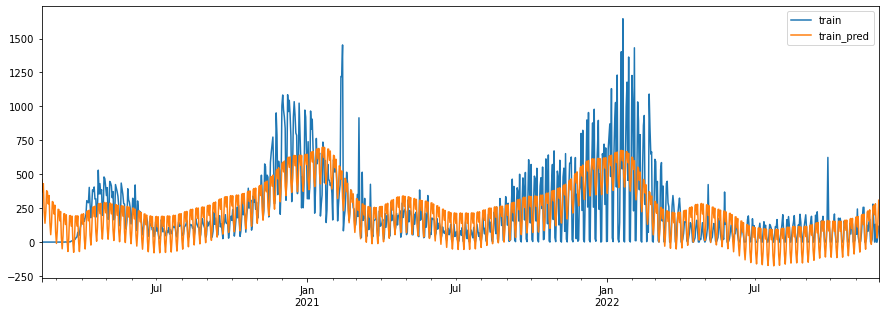

Training Set Metrics:
MAE: 122.3285532616534
MASE: 0.8972389253038613


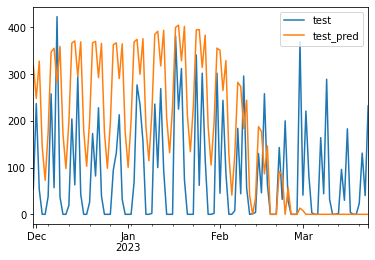

Testing Set Metrics:
MAE: 134.85975362548288
MASE: 1.1654291954481162


In [1275]:
train_pred=midwest_model.predict(midwest_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([midwest_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(midwest_train.values, train_pred['yhat'].values)
mase_train = MASE(midwest_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=midwest_model.predict(midwest_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
midwest_test[midwest_test<0] = 0
pd.concat([midwest_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(midwest_test.values, test_pred['yhat'].values)
mase_test = MASE(midwest_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

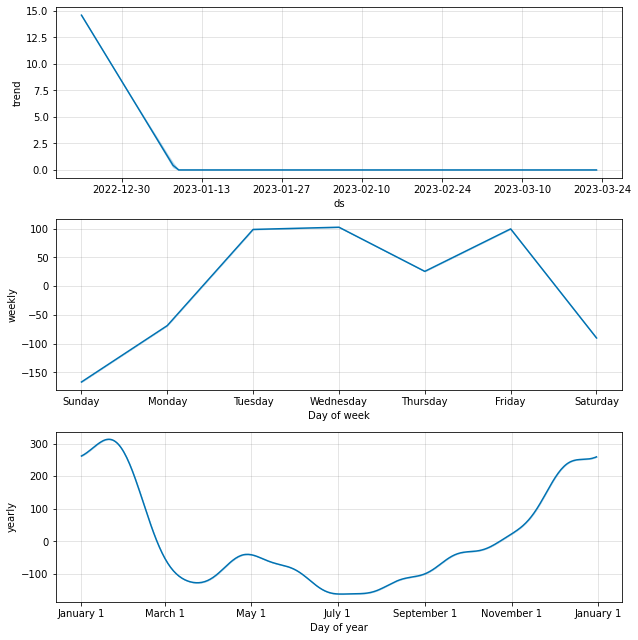

In [122]:
test_pred = test_pred.reset_index()

fig = midwest_model.plot_components(test_pred)
plt.show()

In [1604]:
midwest_model2 = prophet.Prophet(
    changepoint_prior_scale=0.02, # make trend less flexible (default is .05)
    yearly_seasonality = False # get rid of yearly seasonality
)

midwest_model2.add_seasonality(name='weekly', period=7, fourier_order=3) # add weekly (default is 3)
midwest_model2.add_seasonality(name='monthly', period=30.5, fourier_order=3) 

midwest_model2.fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

23:10:50 - cmdstanpy - INFO - Chain [1] start processing
23:10:51 - cmdstanpy - INFO - Chain [1] done processing


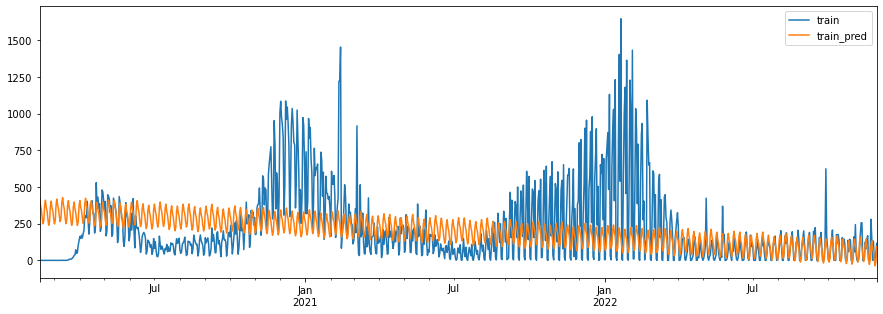

Training Set Metrics:
MAE: 163.8360314108012
MASE: 1.2016823613915606


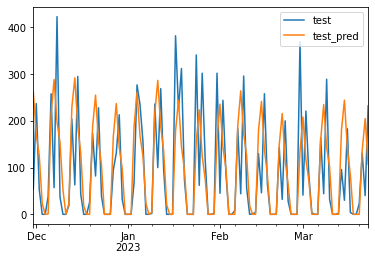

Testing Set Metrics:
MAE: 61.93445441897572
MASE: 0.5352243307849691


In [1605]:
train_pred=midwest_model2.predict(midwest_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([midwest_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(midwest_train.values, train_pred['yhat'].values)
mase_train = MASE(midwest_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=midwest_model2.predict(midwest_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
test_pred = test_pred * 2
midwest_test[midwest_test<0] = 0
pd.concat([midwest_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(midwest_test.values, test_pred['yhat'].values)
mase_test = MASE(midwest_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1583]:
midwest_model3 = prophet.Prophet(
    changepoint_prior_scale=0.02, # make trend less flexible (default is .05)
    yearly_seasonality = False # get rid of yearly seasonality
)

midwest_model3.add_seasonality(name='weekly', period=7, fourier_order=1) # add weekly (default is 3)
midwest_model3.add_seasonality(name='monthly', period=30.5, fourier_order=1) 

midwest_model3.fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing


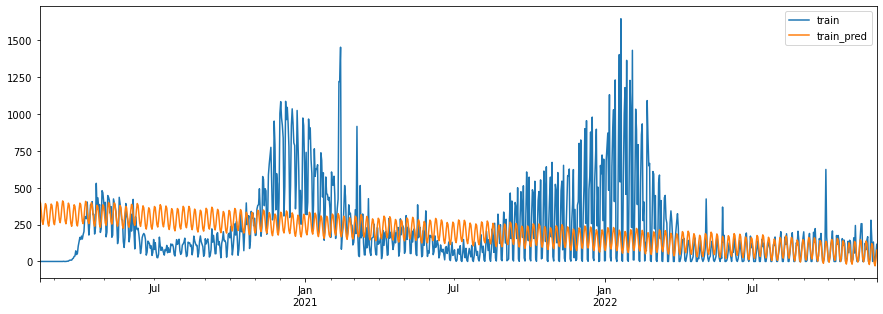

Training Set Metrics:
MAE: 163.94502955107197
MASE: 1.2024818262068393


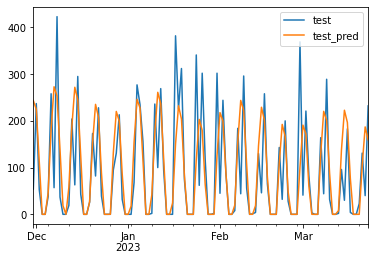

Testing Set Metrics:
MAE: 51.29153243816069
MASE: 0.4432504715136248


In [1590]:
train_pred=midwest_model3.predict(midwest_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([midwest_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(midwest_train.values, train_pred['yhat'].values)
mase_train = MASE(midwest_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=midwest_model3.predict(midwest_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
test_pred = test_pred * 2
midwest_test[midwest_test<0] = 0
pd.concat([midwest_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(midwest_test.values, test_pred['yhat'].values)
mase_test = MASE(midwest_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

### south

In [423]:
south_model = prophet.Prophet().fit(south_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))


03:28:18 - cmdstanpy - INFO - Chain [1] start processing
03:28:19 - cmdstanpy - INFO - Chain [1] done processing


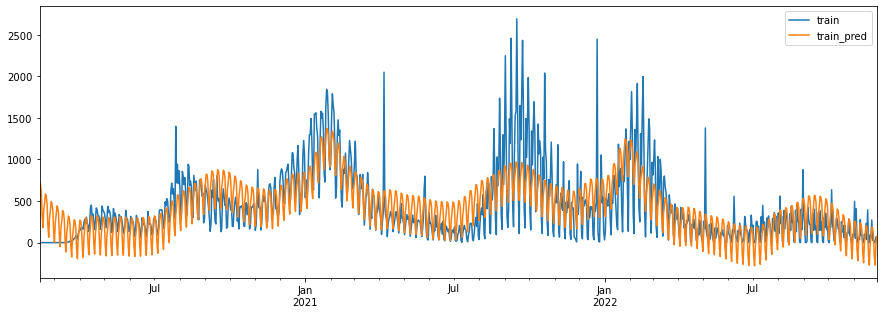

Training Set Metrics:
MAE: 208.75841189868515
MASE: 1.0198832393811936


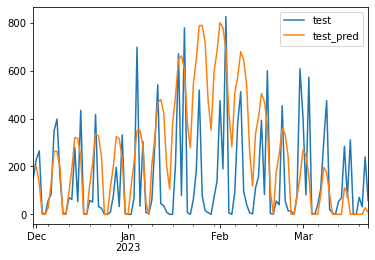

Testing Set Metrics:
MAE: 181.15935254019678
MASE: 0.9371884281940318


In [1277]:
train_pred=south_model.predict(south_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([south_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(south_train.values, train_pred['yhat'].values)
mase_train = MASE(south_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=south_model.predict(south_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
south_test[south_test<0] = 0
pd.concat([south_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(south_test.values, test_pred['yhat'].values)
mase_test = MASE(south_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

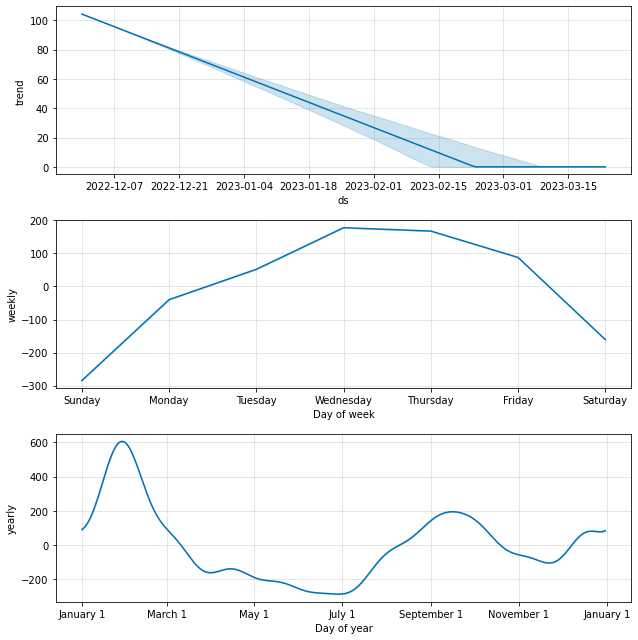

In [425]:
test_pred = test_pred.reset_index()

fig = south_model.plot_components(test_pred)
plt.show()

In [1606]:
south_model2 = prophet.Prophet(
    changepoint_prior_scale=0.02, # make trend less flexible (default is .05)
    yearly_seasonality = False # get rid of yearly seasonality
)

south_model2.add_seasonality(name='weekly', period=7, fourier_order=1) # add weekly (default is 3)
south_model2.add_seasonality(name='monthly', period=30.5, fourier_order=1) 

south_model2.fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

23:11:18 - cmdstanpy - INFO - Chain [1] start processing
23:11:18 - cmdstanpy - INFO - Chain [1] done processing


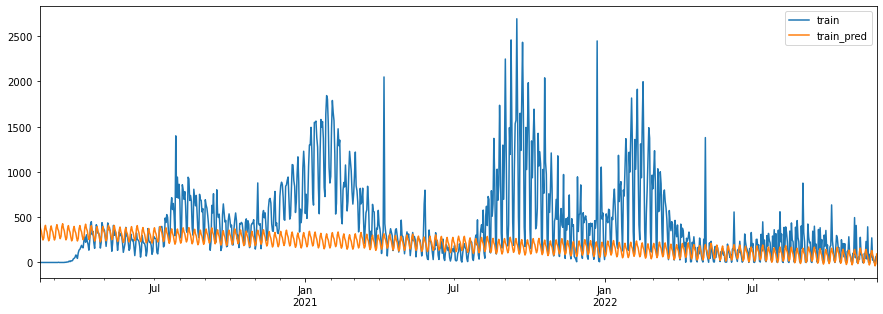

Training Set Metrics:
MAE: 289.8197529305478
MASE: 1.415906098188353


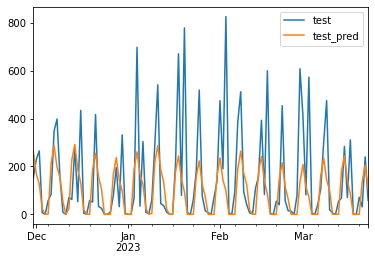

Testing Set Metrics:
MAE: 101.9713873543972
MASE: 0.5275267486630446


In [1607]:
train_pred=south_model2.predict(south_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([south_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(south_train.values, train_pred['yhat'].values)
mase_train = MASE(south_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=south_model2.predict(south_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
test_pred = test_pred * 2
south_test[south_test<0] = 0
pd.concat([south_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(south_test.values, test_pred['yhat'].values)
mase_test = MASE(south_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

### west

In [428]:
west_model = prophet.Prophet().fit(west_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))


03:29:12 - cmdstanpy - INFO - Chain [1] start processing
03:29:12 - cmdstanpy - INFO - Chain [1] done processing


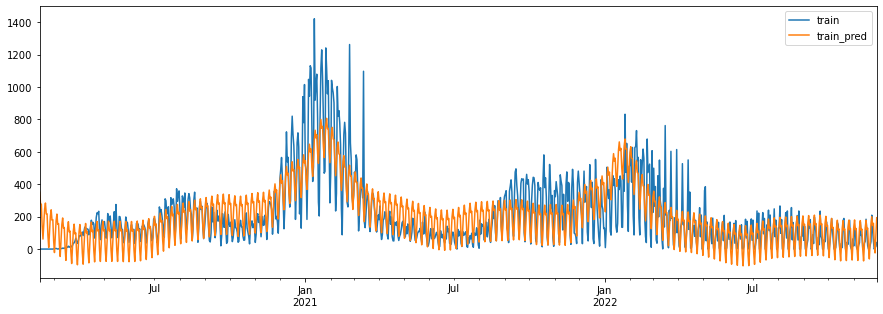

Training Set Metrics:
MAE: 95.048850991629
MASE: 0.9459855814872712


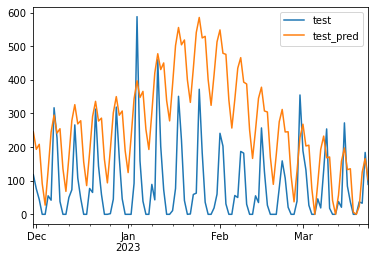

Testing Set Metrics:
MAE: 189.11045001820386
MASE: 2.1139065043087384


In [1279]:
train_pred=west_model.predict(west_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([west_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(west_train.values, train_pred['yhat'].values)
mase_train = MASE(west_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=west_model.predict(west_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
west_test[west_test<0] = 0
pd.concat([west_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(west_test.values, test_pred['yhat'].values)
mase_test = MASE(west_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

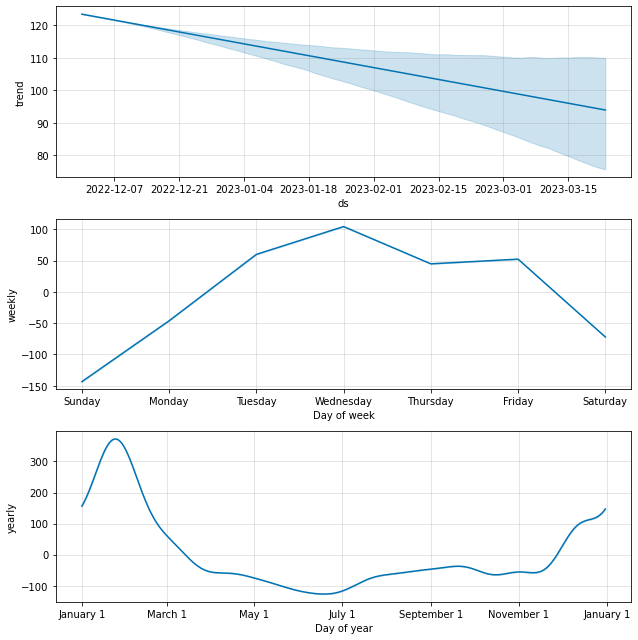

In [430]:
test_pred = test_pred.reset_index()

fig = west_model.plot_components(test_pred)
plt.show()

In [1608]:
west_model2 = prophet.Prophet(
    changepoint_prior_scale=0.02, # make trend less flexible (default is .05)
    yearly_seasonality = False # get rid of yearly seasonality
)

west_model2.add_seasonality(name='weekly', period=7, fourier_order=3) # add weekly (default is 3)
west_model2.add_seasonality(name='monthly', period=30.5, fourier_order=3) 

west_model2.fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

23:11:54 - cmdstanpy - INFO - Chain [1] start processing
23:11:54 - cmdstanpy - INFO - Chain [1] done processing


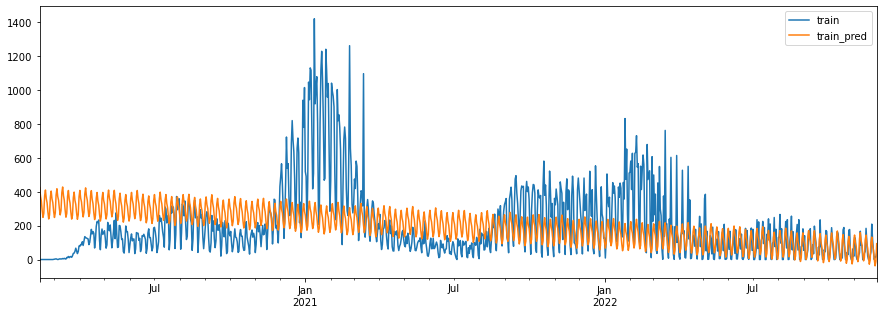

Training Set Metrics:
MAE: 147.13494926819317
MASE: 1.4643789913129006


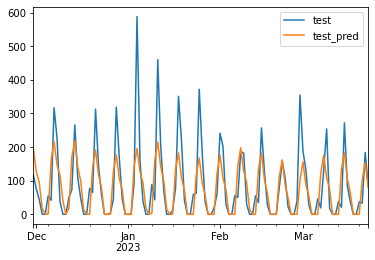

Testing Set Metrics:
MAE: 49.6651674297736
MASE: 0.5551650924487502


In [1609]:
train_pred=west_model2.predict(west_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([west_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(west_train.values, train_pred['yhat'].values)
mase_train = MASE(west_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=west_model2.predict(west_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
test_pred = test_pred * 1.5
west_test[west_test<0] = 0
pd.concat([west_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(west_test.values, test_pred['yhat'].values)
mase_test = MASE(west_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1595]:
west_model2 = prophet.Prophet(
    changepoint_prior_scale=0.02, # make trend less flexible (default is .05)
    yearly_seasonality = False # get rid of yearly seasonality
)

west_model2.add_seasonality(name='weekly', period=7, fourier_order=1) # add weekly (default is 3)
west_model2.add_seasonality(name='monthly', period=30.5, fourier_order=1) 

west_model2.fit(east_train.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

18:16:20 - cmdstanpy - INFO - Chain [1] start processing
18:16:20 - cmdstanpy - INFO - Chain [1] done processing


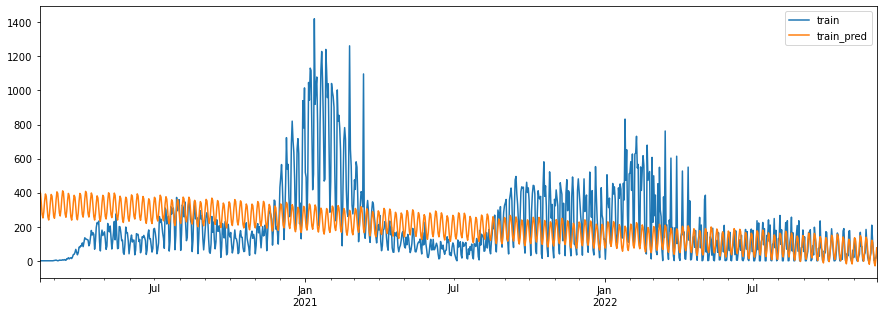

Training Set Metrics:
MAE: 146.67505506253556
MASE: 1.459801836691642


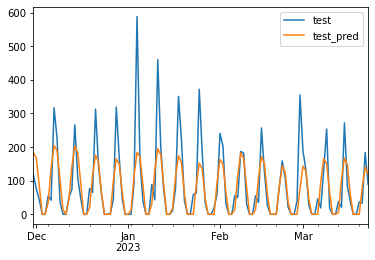

Testing Set Metrics:
MAE: 42.053857466922885
MASE: 0.4700846665112559


In [1596]:
train_pred=west_model2.predict(west_train.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
pd.concat([west_train, train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])
plt.show()

# Calculate metrics

mae_train = mean_absolute_error(west_train.values, train_pred['yhat'].values)
mase_train = MASE(west_train.values, train_pred['yhat'].values)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

test_pred=west_model2.predict(west_test.reset_index().rename(columns={'date':'ds', 'total_purchase_amt':'y'})).set_index('ds')
test_pred[test_pred<0] = 0
test_pred = test_pred * 1.5
west_test[west_test<0] = 0
pd.concat([west_test,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate metrics

mae_test = mean_absolute_error(west_test.values, test_pred['yhat'].values)
mase_test = MASE(west_test.values, test_pred['yhat'].values)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

# Multivariate Prophet

In [1460]:
all_features = pd.read_csv('data/multivar_data/finaldataall.csv')
selected_features = pd.read_csv('data/multivar_data/finaldata_selectedfeatures.csv')

In [1461]:
all_features = all_features.drop(['region_Puerto_Rico'], axis=1)

In [456]:
for col in all_features.columns:
    print(col)

date
location
year
mmwr_week
covid_19_deaths
distributed
distributed_janssen
distributed_moderna
distributed_pfizer
distributed_novavax
distributed_unk_manuf
dist_per_100k
distributed_per_100k_5plus
distributed_per_100k_12plus
distributed_per_100k_18plus
distributed_per_100k_65plus
administered
administered_5plus
administered_12plus
administered_18plus
administered_65plus
administered_janssen
administered_moderna
administered_pfizer
administered_novavax
administered_unk_manuf
admin_per_100k
admin_per_100k_5plus
admin_per_100k_12plus
admin_per_100k_18plus
admin_per_100k_65plus
recip_administered
administered_dose1_recip
administered_dose1_pop_pct
administered_dose1_recip_5plus
administered_dose1_recip_5plus_pop_pct
administered_dose1_recip_12plus
administered_dose1_recip_12plus_pop_pct
administered_dose1_recip_18plus
administered_dose1_recip_18plus_pop_pct
administered_dose1_recip_65plus
administered_dose1_recip_65plus_pop_pct
series_complete_yes
series_complete_pop_pct
series_complete_

In [443]:
all_features.head()

date location  year  mmwr_week  covid_19_deaths  distributed  \
0  2020-01-04       AL  2020          1              0.0          0.0   
1  2020-01-04       LA  2020          1              0.0          0.0   
2  2020-01-04       VA  2020          1              0.0          0.0   
3  2020-01-04       KY  2020          1              0.0          0.0   
4  2020-01-04       KS  2020          1              0.0          0.0   

   distributed_janssen  distributed_moderna  distributed_pfizer  \
0                  0.0                  0.0                 0.0   
1                  0.0                  0.0                 0.0   
2                  0.0                  0.0                 0.0   
3                  0.0                  0.0                 0.0   
4                  0.0                  0.0                 0.0   

   distributed_novavax  ...  quarter  dayofyear  dayofmonth  weekofyear  \
0                  0.0  ...        1          4           4           1   
1                  0.0  ...        1          4           4           1   
2                  0.0  ...        1          4           4           1   
3                  0.0  ...        1          4           4           1   
4                  0.0  ...        1          4           4           1   

   holidays_Holiday  holidays_Normal_day  month_sin  month_cos  dayofweek_sin  \
0                 0                    1        0.5   0.866025      -0.974928   
1                 0                    1        0.5   0.866025      -0.974928   
2                 0                    1        0.5   0.866025      -0.974928   
3                 0                    1        0.5   0.866025      -0.974928   
4                 0                    1        0.5   0.866025      -0.974928   

   dayofweek_cos  
0      -0.222521  
1      -0.222521  
2      -0.222521  
3      -0.222521  
4      -0.222521  

[5 rows x 146 columns]

In [444]:
all_features.tail()

date location  year  mmwr_week  covid_19_deaths  distributed  \
7301  2023-02-25       CO  2023          8             22.0   17340235.0   
7302  2023-02-25       MI  2023          8             69.0   28917130.0   
7303  2023-02-25       MD  2023          8             45.0   21829280.0   
7304  2023-02-25       LA  2023          8             24.0   10141420.0   
7305  2023-02-25       NM  2023          8             10.0    6047345.0   

      distributed_janssen  distributed_moderna  distributed_pfizer  \
7301             501900.0            6060640.0          10749595.0   
7302             967600.0           11182320.0          16740610.0   
7303             616400.0            7305760.0          13876420.0   
7304             330300.0            4094680.0           5707940.0   
7305             190600.0            2338600.0           3511145.0   

      distributed_novavax  ...  quarter  dayofyear  dayofmonth  weekofyear  \
7301              28100.0  ...        1         56          25           8   
7302              26600.0  ...        1         56          25           8   
7303              30700.0  ...        1         56          25           8   
7304               8500.0  ...        1         56          25           8   
7305               7000.0  ...        1         56          25           8   

      holidays_Holiday  holidays_Normal_day  month_sin  month_cos  \
7301                 0                    1   0.866025        0.5   
7302                 0                    1   0.866025        0.5   
7303                 0                    1   0.866025        0.5   
7304                 0                    1   0.866025        0.5   
7305                 0                    1   0.866025        0.5   

      dayofweek_sin  dayofweek_cos  
7301      -0.974928      -0.222521  
7302      -0.974928      -0.222521  
7303      -0.974928      -0.222521  
7304      -0.974928      -0.222521  
7305      -0.974928      -0.222521  

[5 rows x 146 columns]

In [463]:
all_features.loc[all_features['region_East'] == 1]

date location  year  mmwr_week  covid_19_deaths  distributed  \
11    2020-01-04       ME  2020          1              0.0          0.0   
17    2020-01-04       CT  2020          1              0.0          0.0   
25    2020-01-04       MA  2020          1              0.0          0.0   
26    2020-01-04       PA  2020          1              0.0          0.0   
34    2020-01-04       NY  2020          1              0.0          0.0   
...          ...      ...   ...        ...              ...          ...   
7277  2023-02-25       CT  2023          8             22.0   11677565.0   
7283  2023-02-25       PA  2023          8            110.0   41739215.0   
7284  2023-02-25       MA  2023          8             59.0   23152420.0   
7292  2023-02-25       ME  2023          8             10.0    4845030.0   
7295  2023-02-25       NY  2023          8            129.0   60163375.0   

      distributed_janssen  distributed_moderna  distributed_pfizer  \
11                    0.0                  0.0                 0.0   
17                    0.0                  0.0                 0.0   
25                    0.0                  0.0                 0.0   
26                    0.0                  0.0                 0.0   
34                    0.0                  0.0                 0.0   
...                   ...                  ...                 ...   
7277             355100.0            4514680.0           6799185.0   
7283            1569200.0           15502820.0          24610095.0   
7284             633400.0            8775580.0          13731440.0   
7292             159400.0            1817620.0           2861610.0   
7295            1964400.0           20863780.0          37303395.0   

      distributed_novavax  ...  quarter  dayofyear  dayofmonth  weekofyear  \
11                    0.0  ...        1          4           4           1   
17                    0.0  ...        1          4           4           1   
25                    0.0  ...        1          4           4           1   
26                    0.0  ...        1          4           4           1   
34                    0.0  ...        1          4           4           1   
...                   ...  ...      ...        ...         ...         ...   
7277               8600.0  ...        1         56          25           8   
7283              57100.0  ...        1         56          25           8   
7284              12000.0  ...        1         56          25           8   
7292               6400.0  ...        1         56          25           8   
7295              31800.0  ...        1         56          25           8   

      holidays_Holiday  holidays_Normal_day  month_sin  month_cos  \
11                   0                    1   0.500000   0.866025   
17                   0                    1   0.500000   0.866025   
25                   0                    1   0.500000   0.866025   
26                   0                    1   0.500000   0.866025   
34                   0                    1   0.500000   0.866025   
...                ...                  ...        ...        ...   
7277                 0                    1   0.866025   0.500000   
7283                 0                    1   0.866025   0.500000   
7284                 0                    1   0.866025   0.500000   
7292                 0                    1   0.866025   0.500000   
7295                 0                    1   0.866025   0.500000   

      dayofweek_sin  dayofweek_cos  
11        -0.974928      -0.222521  
17        -0.974928      -0.222521  
25        -0.974928      -0.222521  
26        -0.974928      -0.222521  
34        -0.974928      -0.222521  
...             ...            ...  
7277      -0.974928      -0.222521  
7283      -0.974928      -0.222521  
7284      -0.974928      -0.222521  
7292      -0.974928      -0.222521  
7295      -0.974928      -0.222521  

[1193 rows x 145 columns]

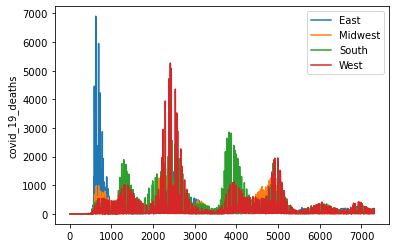

In [476]:
# blue line - East
sns.lineplot(x =  all_features.loc[all_features['region_East'] == 1].index, y = all_features.loc[all_features['region_East'] == 1]['covid_19_deaths'])

# orange line - Midwest
sns.lineplot(x =  all_features.loc[all_features['region_Midwest'] == 1].index, y = all_features.loc[all_features['region_Midwest'] == 1]['covid_19_deaths'])

# green line - South
sns.lineplot(x =  all_features.loc[all_features['region_South'] == 1].index, y = all_features.loc[all_features['region_South'] == 1]['covid_19_deaths'])

# red line - West
sns.lineplot(x =  all_features.loc[all_features['region_West'] == 1].index, y = all_features.loc[all_features['region_West'] == 1]['covid_19_deaths'])

plt.legend(labels = ['East', 'Midwest', 'South', 'West'])


# Data Processing

In [1283]:
multi_prophet = all_features

multi_prophet = multi_prophet.rename(columns={'date': 'ds', 'covid_19_deaths': 'y'})

multi_prophet = multi_prophet.drop(['year','month','deaths_1_year_lag','deaths_1_andhalf_year_lag', 'deaths_2_years_lag',
       'deaths_half_year_lag_mean', 'deaths_1_year_lag_mean',
       'deaths_1_andhalf_year_lag_mean', 'deaths_2_years_lag_mean',
       'deaths_half_year_lag_std', 'deaths_1_year_lag_std',
       'deaths_1_andhalf_year_lag_std', 'deaths_2_years_lag_std','deaths_half_year_lag_max', 'deaths_1_year_lag_max',
       'deaths_1_andhalf_year_lag_max', 'deaths_2_years_lag_max',
       'deaths_half_year_lag_min', 'deaths_1_year_lag_min',
       'deaths_1_andhalf_year_lag_min', 'deaths_2_years_lag_min', 'date.1',
       'dayofweek', 'quarter', 'dayofyear', 'dayofmonth', 'weekofyear', 'holidays_Holiday',
       'holidays_Normal_day', 'month_sin', 'month_cos', 'dayofweek_sin',
       'dayofweek_cos', 'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter',
       'deaths_half_year_lag', 'mmwr_week'], axis=1)

In [1464]:
multi_prophet = selected_features

multi_prophet = multi_prophet.rename(columns={'date': 'ds', 'covid_19_deaths': 'y'})

multi_prophet = multi_prophet.drop(['year','month','deaths_1_year_lag','deaths_1_andhalf_year_lag', 'deaths_2_years_lag',
       'deaths_half_year_lag_mean', 'deaths_1_year_lag_mean',
       'deaths_1_andhalf_year_lag_mean', 'deaths_2_years_lag_mean',
       'deaths_half_year_lag_std', 'deaths_1_year_lag_std',
       'deaths_1_andhalf_year_lag_std', 'deaths_2_years_lag_std','deaths_half_year_lag_max', 'deaths_1_year_lag_max',
       'deaths_1_andhalf_year_lag_max', 'deaths_2_years_lag_max',
       'deaths_half_year_lag_min', 'deaths_1_year_lag_min',
       'deaths_1_andhalf_year_lag_min', 'deaths_2_years_lag_min',
       'dayofweek', 'quarter', 'dayofyear', 'dayofmonth', 'weekofyear', 
        'month_cos','season_Spring', 'season_Winter',
       'deaths_half_year_lag', 'mmwr_week'], axis=1)

In [1465]:
for col in multi_prophet.columns:
    print(col)

ds
y
administered_5plus
distributed_novavax
series_complete_moderna_65plus
administered_dose1_recip_18plus
additional_doses_12plus
administered_dose1_recip_65plus
administered_dose1_recip_12plus
administered_dose1_recip_18plus_pop_pct
second_booster_65plus
series_complete_janssen_5plus
admin_per_100k_18plus
series_complete_65plus_pop_pct
series_complete_pfizer_65plus
second_booster_janssen
admin_per_100k_65plus
series_complete_moderna_5plus
distributed_moderna
admin_bivalent_mod
administered_65plus
admin_per_100k
administered_12plus
series_complete_moderna
series_complete_12plus
recip_administered
bivalent_booster_5plus
bivalent_booster_65plus
series_complete_65plus
additional_doses_50plus
distributed_janssen
additional_doses_5plus
series_complete_unk_manuf_12plus
additional_doses
admin_bivalent_pfr
series_complete_18plus_pop_pct
administered
distributed
distributed_per_100k_18plus
series_complete_pop_pct
administered_pfizer
administered_bivalent
series_complete_janssen_65plus
administ

In [1466]:
start_date = '2020-01-04'
end_date = '2023-02-25'
train_end_date = '2022-12-31'

In [1467]:
# Train test split
train = multi_prophet[multi_prophet['ds'] <= train_end_date]
test = multi_prophet[multi_prophet['ds'] > train_end_date]

# Check the shape of the dataset
print(train.shape)
print(test.shape)

(6974, 62)
(332, 62)


In [1468]:
# Check the start and end time of the training and testing dataset
print('The start time of the training dataset is ', train['ds'].min())
print('The end time of the training dataset is ', train['ds'].max())
print('The start time of the testing dataset is ', test['ds'].min())
print('The end time of the testing dataset is ', test['ds'].max())

The start time of the training dataset is  2020-01-04
The end time of the training dataset is  2022-12-31
The start time of the testing dataset is  2023-01-07
The end time of the testing dataset is  2023-02-25


In [1469]:
train = train.fillna(1000000)
test = test.fillna(1000000)

In [1470]:
train['log_deaths'] = np.log1p(train['y'])
test['log_deaths'] = np.log1p(test['y'])

In [1471]:
train_log = train.drop(['y'], axis = 1)
train_log = train_log.rename(columns={'log_deaths':'y'})

test_log = test.drop(['y'], axis = 1)
test_log = test_log.rename(columns={'log_deaths':'y'})

# Baseline Model

In [1346]:
# Use the default hyperparameters to initiate the Prophet model
model_baseline = prophet.Prophet()

# Fit the model on the training dataset
model_baseline.fit(train_log)

13:03:50 - cmdstanpy - INFO - Chain [1] start processing
13:03:53 - cmdstanpy - INFO - Chain [1] done processing


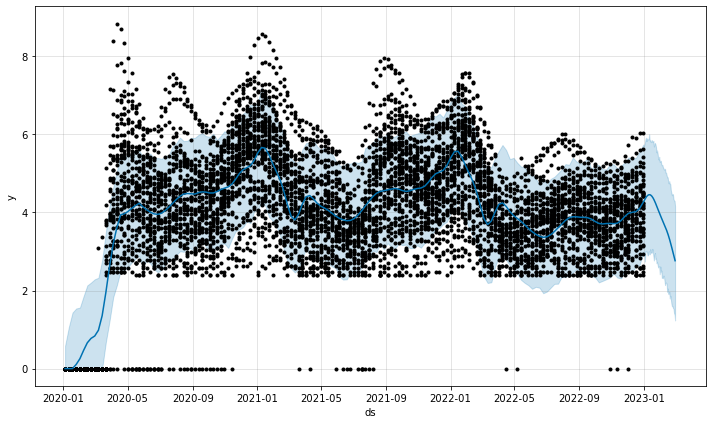

In [1347]:
# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=60)

# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_baseline[col] = forecast_baseline[col].clip(lower=0.0)

# Visualize the forecast
model_baseline.plot(forecast_baseline); # Add semi-colon to remove the duplicated chart

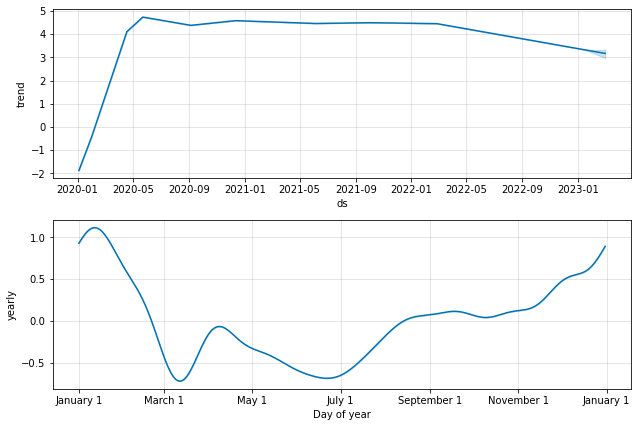

In [1348]:
model_baseline.plot_components(forecast_baseline);

In [1349]:
test['ds'] = pd.to_datetime(test['ds'])
#df['col'] = pd.to_datetime(df['col'])

In [1350]:
def MASE(Actual, Predicted):
    n = len(Actual)
    
    mae = mean_absolute_error(Actual, Predicted)

    # Calculate the denominator
    denominator = (1 / (n - 1)) * np.sum(np.abs(Actual.values[1:] - Actual.values[:-1]))

    # Avoid division by zero or small denominators
    if denominator > 1e-6:
        mase = mae / denominator
    else:
        mase = np.inf

    return mase

In [1354]:
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-60:], on='ds')
performance_baseline['yhat'] = np.expm1(performance_baseline['yhat'])

# Check MAE value
performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')

# Check MASE value
performance_baseline_MASE = MASE(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MASE for the baseline model is {performance_baseline_MASE}')

The MAE for the baseline model is 43.83141972500174
The MASE for the baseline model is 0.717517306081878


## Tuning Changepoints

In [1355]:
print(f'There are {len(model_baseline.changepoints)} change points. \nThe change points dates are \n{train.loc[train["ds"].isin(model_baseline.changepoints)]}')

There are 25 change points. 
The change points dates are 
Empty DataFrame
Columns: [ds, location, y, distributed, distributed_janssen, distributed_moderna, distributed_pfizer, distributed_novavax, distributed_unk_manuf, dist_per_100k, distributed_per_100k_5plus, distributed_per_100k_12plus, distributed_per_100k_18plus, distributed_per_100k_65plus, administered, administered_5plus, administered_12plus, administered_18plus, administered_65plus, administered_janssen, administered_moderna, administered_pfizer, administered_novavax, administered_unk_manuf, admin_per_100k, admin_per_100k_5plus, admin_per_100k_12plus, admin_per_100k_18plus, admin_per_100k_65plus, recip_administered, administered_dose1_recip, administered_dose1_pop_pct, administered_dose1_recip_5plus, administered_dose1_recip_5plus_pop_pct, administered_dose1_recip_12plus, administered_dose1_recip_12plus_pop_pct, administered_dose1_recip_18plus, administered_dose1_recip_18plus_pop_pct, administered_dose1_recip_65plus, administ

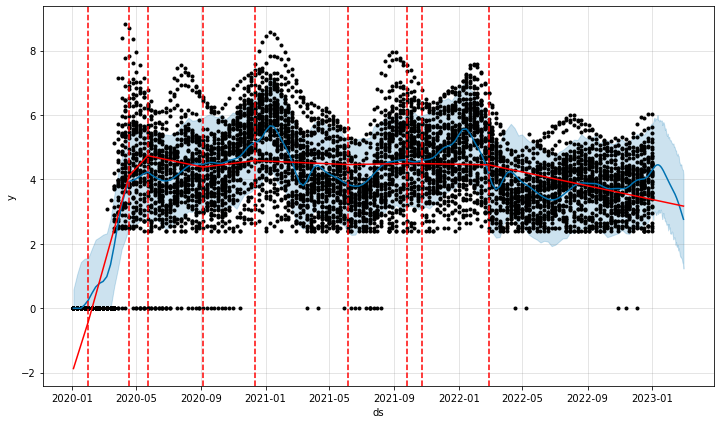

In [1356]:
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)

In [1375]:
# Create the prophet model with confidence internal of 95%
model_changepoint = prophet.Prophet(interval_width=0.95, n_changepoints=3)
# Fit the model using the training dataset
model_changepoint.fit(train_log)


13:12:07 - cmdstanpy - INFO - Chain [1] start processing
13:12:08 - cmdstanpy - INFO - Chain [1] done processing


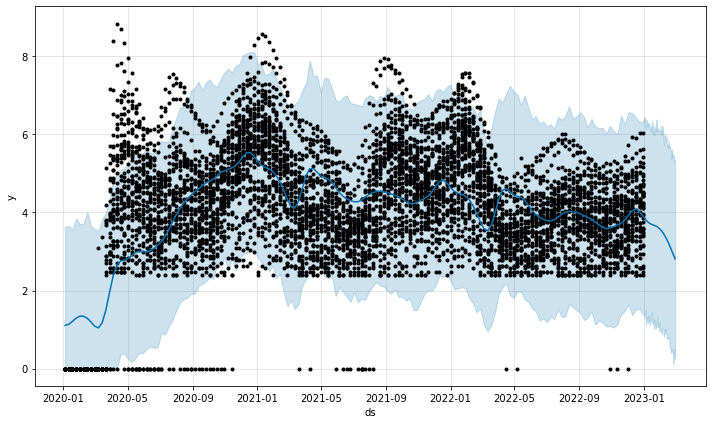

In [1376]:
# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=60)

# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_changepoint[col] = forecast_changepoint[col].clip(lower=0.0)

# Visualize the forecast
model_changepoint.plot(forecast_changepoint); # Add semi-colon to remove the duplicated chart

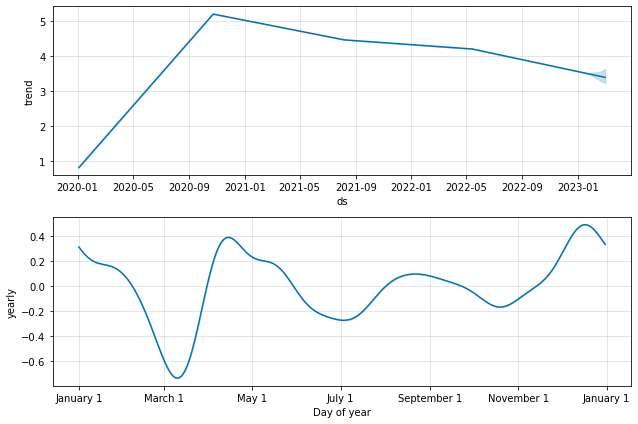

In [1377]:
# Visualize the forecast components
model_changepoint.plot_components(forecast_changepoint);

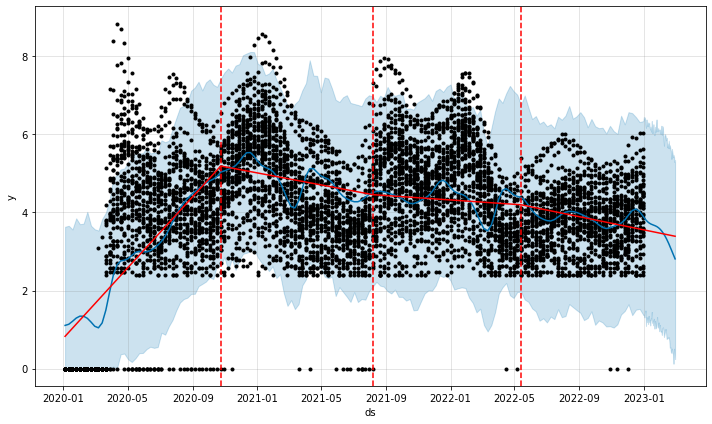

In [1378]:
# Change points to plot
fig = model_changepoint.plot(forecast_changepoint)
a = add_changepoints_to_plot(fig.gca(), model_changepoint, forecast_changepoint)

In [1379]:
# Merge actual and predicted values
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-60:], on='ds')
performance_changepoint['yhat'] = np.expm1(performance_changepoint['yhat'])

# Check MAE value
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
print(f'The MAE for the baseline model is {performance_changepoint_MAE}')

# Check MAPE value
performance_changepoint_MASE = MASE(performance_changepoint['y'], performance_changepoint['yhat'])
print(f'The MASE for the baseline model is {performance_changepoint_MASE}')

The MAE for the baseline model is 44.2069617154945
The MASE for the baseline model is 0.7236649024643264


## Add Seasonality

In [1380]:
# Add seasonality
model_season = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=True, n_changepoints = 3)

# Fit the model on the training dataset
model_season.fit(train_log)

13:12:22 - cmdstanpy - INFO - Chain [1] start processing
13:12:22 - cmdstanpy - INFO - Chain [1] done processing


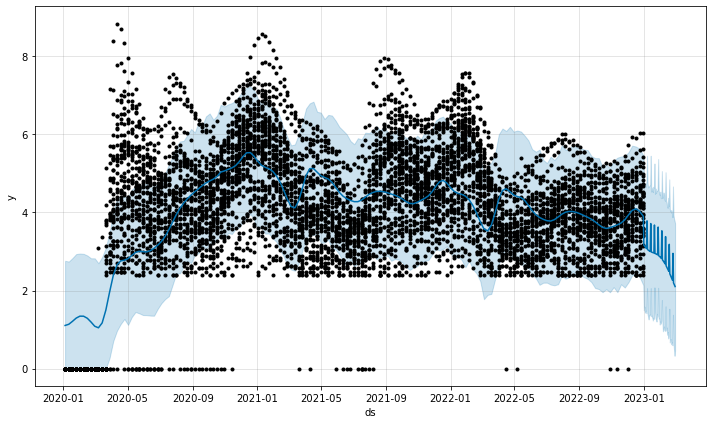

In [1381]:
# Create the time range for the forecast
future_season = model_season.make_future_dataframe(periods=60)

# Make prediction
forecast_season = model_season.predict(future_season)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_season[col] = forecast_season[col].clip(lower=0.0)

# Visualize the forecast
model_season.plot(forecast_season); # Add semi-colon to remove the duplicated chart

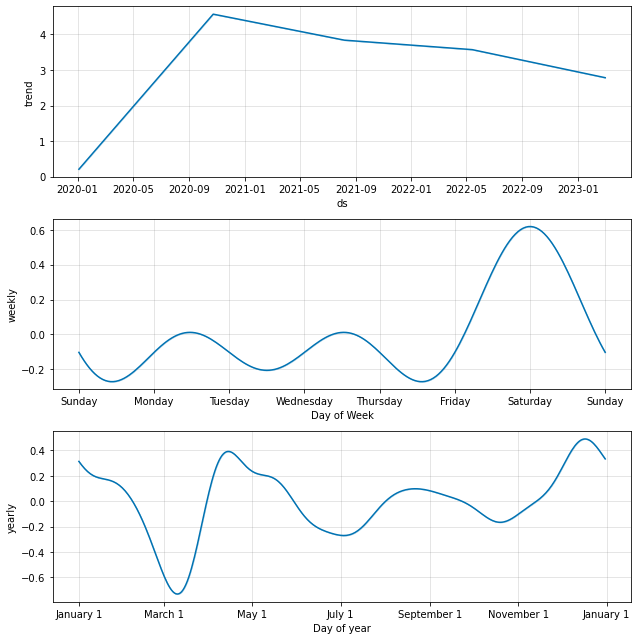

In [1382]:
model_season.plot_components(forecast_season);

In [1383]:
# Merge actual and predicted values
performance_season = pd.merge(test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-60:], on='ds')
performance_season['yhat'] = np.expm1(performance_season['yhat'])

# Check MAE value
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

# Check MASE value
performance_baseline_MASE = MASE(performance_season['y'], performance_season['yhat'])
print(f'The MASE for the baseline model is {performance_baseline_MASE}')

The MAE for the seasonality model is 44.0765999116243
The MASE for the baseline model is 0.721530888761011


### no yearly seasonality

In [1370]:
# Add seasonality
model_season = prophet.Prophet(yearly_seasonality=False, weekly_seasonality=True, n_changepoints = 3)

# Fit the model on the training dataset
model_season.fit(train_log)

# Create the time range for the forecast
future_season = model_season.make_future_dataframe(periods=60)

# Make prediction
forecast_season = model_season.predict(future_season)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_season[col] = forecast_season[col].clip(lower=0.0)
    
# Merge actual and predicted values
performance_season = pd.merge(test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-60:], on='ds')
performance_season['yhat'] = np.expm1(performance_season['yhat'])

# Check MAE value
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

# Check MASE value
performance_season_MASE = MASE(performance_season['y'], performance_season['yhat'])
print(f'The MASE for the baseline model is {performance_season_MASE}')

13:11:24 - cmdstanpy - INFO - Chain [1] start processing
13:11:24 - cmdstanpy - INFO - Chain [1] done processing


The MAE for the seasonality model is 42.38900261936758
The MASE for the baseline model is 0.6939050379332675


### no weekly seasonality

In [1369]:
# Add seasonality
model_season = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=False, n_changepoints = 3)

# Fit the model on the training dataset
model_season.fit(train_log)

# Create the time range for the forecast
future_season = model_season.make_future_dataframe(periods=60)

# Make prediction
forecast_season = model_season.predict(future_season)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_season[col] = forecast_season[col].clip(lower=0.0)
    
# Merge actual and predicted values
performance_season = pd.merge(test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-60:], on='ds')
performance_season['yhat'] = np.expm1(performance_season['yhat'])

# Check MAE value
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

# Check MASE value
performance_season_MASE = MASE(performance_season['y'], performance_season['yhat'])
print(f'The MASE for the baseline model is {performance_season_MASE}')

13:11:15 - cmdstanpy - INFO - Chain [1] start processing
13:11:15 - cmdstanpy - INFO - Chain [1] done processing


The MAE for the seasonality model is 44.2069617154945
The MASE for the baseline model is 0.7236649024643264


### neither yearly or weekly seasonality

In [1330]:
# Add seasonality
model_season = prophet.Prophet(yearly_seasonality=False, weekly_seasonality=False, n_changepoints = 3)

# Fit the model on the training dataset
model_season.fit(train)

# Create the time range for the forecast
future_season = model_season.make_future_dataframe(periods=60)

# Make prediction
forecast_season = model_season.predict(future_season)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_season[col] = forecast_season[col].clip(lower=0.0)
    
# Merge actual and predicted values
performance_season = pd.merge(test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-60:], on='ds')

# Check MAE value
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

# Check MASE value
performance_season_MASE = MASE(performance_season['y'], performance_season['yhat'])
print(f'The MASE for the baseline model is {performance_season_MASE}')

12:01:09 - cmdstanpy - INFO - Chain [1] start processing
12:01:09 - cmdstanpy - INFO - Chain [1] done processing


The MAE for the seasonality model is 47.32220396200185
The MASE for the baseline model is 0.774661202345332


best so far:
- no yearly and no weekly
- no yearly, yes weekly

## adding holiday effect

In [1384]:
# Add holidays
model_holiday = prophet.Prophet(n_changepoints=3)

# Add built-in country-specific holidays
model_holiday.add_country_holidays(country_name='US')


# Fit the model on the training dataset
model_holiday.fit(train_log)

# All the holidays and events
model_holiday.train_holiday_names

13:12:37 - cmdstanpy - INFO - Chain [1] start processing
13:12:38 - cmdstanpy - INFO - Chain [1] done processing


0                                      New Year's Day
1                                        Memorial Day
2                                    Independence Day
3                         Independence Day (observed)
4                                           Labor Day
5                                        Veterans Day
6                                        Thanksgiving
7                                       Christmas Day
8                          Martin Luther King Jr. Day
9                               Washington's Birthday
10                                       Columbus Day
11                          New Year's Day (observed)
12               Juneteenth National Independence Day
13    Juneteenth National Independence Day (observed)
14                           Christmas Day (observed)
dtype: object

The MAE for the seasonality model is 43.68971595024983
The MASE for the baseline model is 0.7151976251005288


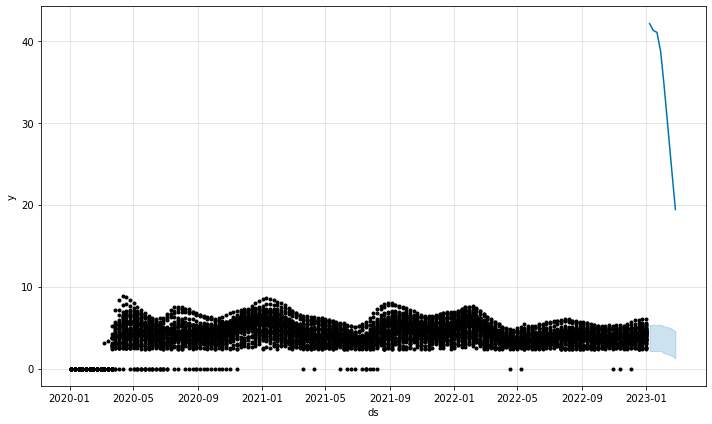

In [1385]:
# Create the time range for the forecast
future_holiday = model_holiday.make_future_dataframe(periods=60)

# Make prediction
forecast_holiday = model_holiday.predict(future_holiday)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_holiday[col] = forecast_holiday[col].clip(lower=0.0)
    
# Merge actual and predicted values
performance_holiday = pd.merge(test, forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-60:], on='ds')
performance_holiday['yhat'] = np.expm1(performance_holiday['yhat'])

# Check MAE value
performance_holiday_MAE = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAE for the seasonality model is {performance_holiday_MAE}')

# Check MASE value
performance_holiday_MASE = MASE(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MASE for the baseline model is {performance_holiday_MASE}')

# Visualize the forecast
model_holiday.plot(performance_holiday); # Add semi-colon to remove the duplicated chart

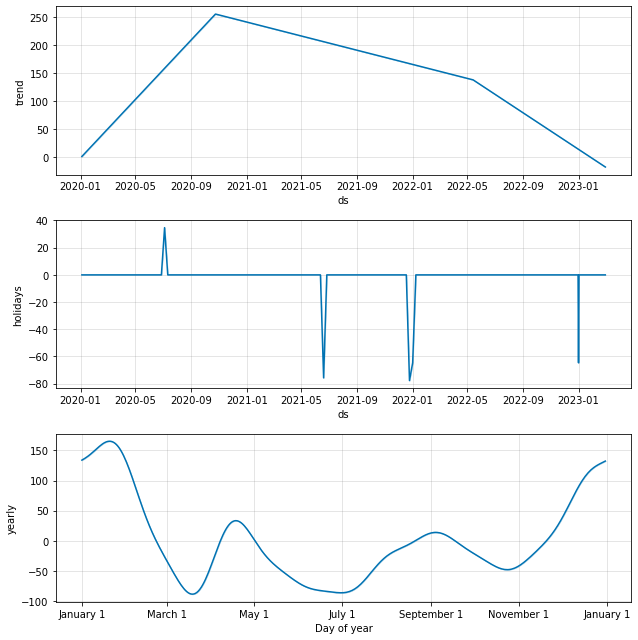

In [880]:
model_holiday.plot_components(forecast_holiday);

## Seasonality and Holidays

In [1386]:
model_season = prophet.Prophet(yearly_seasonality=False, weekly_seasonality=True, n_changepoints = 3)
model_season.add_country_holidays(country_name='US')

In [1387]:
# Fit the model on the training dataset
model_season.fit(train_log)

# Create the time range for the forecast
future_season = model_season.make_future_dataframe(periods=60)

# Make prediction
forecast_season = model_season.predict(future_season)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_season[col] = forecast_season[col].clip(lower=0.0)
    
# Merge actual and predicted values
performance_season = pd.merge(test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-60:], on='ds')
performance_season['yhat'] = np.expm1(performance_season['yhat'])

# Check MAE value
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

# Check MASE value
performance_season_MASE = MASE(performance_season.set_index('ds')['y'], performance_season.set_index('ds')['yhat'])
print(f'The MASE for the baseline model is {performance_season_MASE}')

13:13:08 - cmdstanpy - INFO - Chain [1] start processing
13:13:08 - cmdstanpy - INFO - Chain [1] done processing


The MAE for the seasonality model is 42.205300608200325
The MASE for the baseline model is 0.6908978487296887


# Multivariate Model

In [1472]:
multi_prophet.columns

Index(['ds', 'y', 'administered_5plus', 'distributed_novavax',
       'series_complete_moderna_65plus', 'administered_dose1_recip_18plus',
       'additional_doses_12plus', 'administered_dose1_recip_65plus',
       'administered_dose1_recip_12plus',
       'administered_dose1_recip_18plus_pop_pct', 'second_booster_65plus',
       'series_complete_janssen_5plus', 'admin_per_100k_18plus',
       'series_complete_65plus_pop_pct', 'series_complete_pfizer_65plus',
       'second_booster_janssen', 'admin_per_100k_65plus',
       'series_complete_moderna_5plus', 'distributed_moderna',
       'admin_bivalent_mod', 'administered_65plus', 'admin_per_100k',
       'administered_12plus', 'series_complete_moderna',
       'series_complete_12plus', 'recip_administered',
       'bivalent_booster_5plus', 'bivalent_booster_65plus',
       'series_complete_65plus', 'additional_doses_50plus',
       'distributed_janssen', 'additional_doses_5plus',
       'series_complete_unk_manuf_12plus', 'additional_do

In [1473]:
feature_list = ['administered_5plus', 'distributed_novavax',
       'series_complete_moderna_65plus', 'administered_dose1_recip_18plus',
       'additional_doses_12plus', 'administered_dose1_recip_65plus',
       'administered_dose1_recip_12plus',
       'administered_dose1_recip_18plus_pop_pct', 'second_booster_65plus',
       'series_complete_janssen_5plus', 'admin_per_100k_18plus',
       'series_complete_65plus_pop_pct', 'series_complete_pfizer_65plus',
       'second_booster_janssen', 'admin_per_100k_65plus',
       'series_complete_moderna_5plus', 'distributed_moderna',
       'admin_bivalent_mod', 'administered_65plus', 'admin_per_100k',
       'administered_12plus', 'series_complete_moderna',
       'series_complete_12plus', 'recip_administered',
       'bivalent_booster_5plus', 'bivalent_booster_65plus',
       'series_complete_65plus', 'additional_doses_50plus',
       'distributed_janssen', 'additional_doses_5plus',
       'series_complete_unk_manuf_12plus', 'additional_doses',
       'admin_bivalent_pfr', 'series_complete_18plus_pop_pct', 'administered',
       'distributed', 'distributed_per_100k_18plus', 'series_complete_pop_pct',
       'administered_pfizer', 'administered_bivalent',
       'series_complete_janssen_65plus', 'administered_janssen',
       'series_complete_12plus_pop_pct', 'bivalent_booster_12plus',
       'administered_unk_manuf', 'series_complete_pfizer_5plus',
       'additional_doses_vax_pct', 'additional_doses_50plus_vax_pct',
       'administered_dose1_recip_65plus_pop_pct', 'administered_moderna',
       'region_West', 'dist_bivalent_pfr', 'administered_dose1_recip_5plus',
       'series_complete_unk_manuf', 'distributed_per_100k_12plus',
       'second_booster_moderna', 'second_booster_pfizer', 'region_East',
       'dist_per_100k', 'admin_per_100k_12plus']

In [1391]:
# Set the correlation threshold
correlation_threshold = 0.05

# Create a correlation matrix
correlation_matrix = multi_prophet.corr()

# Extract the correlations with the target variable above the threshold
correlations_above_threshold = correlation_matrix['y'][correlation_matrix['y'].abs() > correlation_threshold]

# Sort the correlations in descending order
correlated_list = list(correlations_above_threshold.index)
correlated_list.remove('y')

In [1392]:
model = prophet.Prophet(yearly_seasonality=False, weekly_seasonality=True, n_changepoints = 3)
model.add_country_holidays(country_name='US')

for feature in correlated_list:
    model.add_regressor(feature)
        
model=model.fit(train_log)

13:31:15 - cmdstanpy - INFO - Chain [1] start processing
13:31:42 - cmdstanpy - INFO - Chain [1] done processing


In [1393]:
feature_list_copy = feature_list.copy()
feature_list_copy.append('ds')

In [1402]:
multi_prophet['ds'] = pd.to_datetime(multi_prophet['ds'])
multi_prophet = multi_prophet.fillna(1000000)

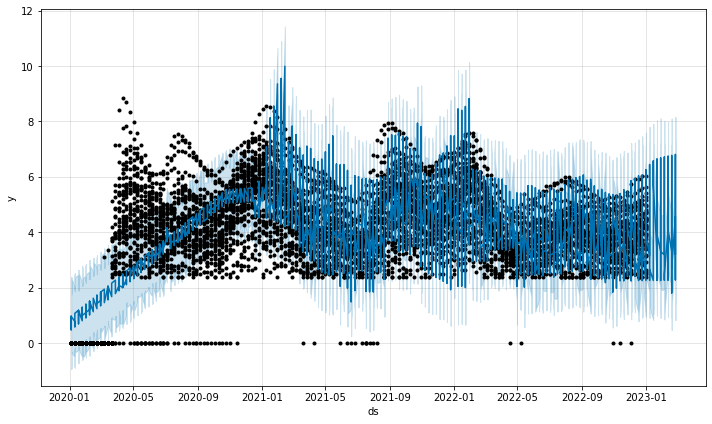

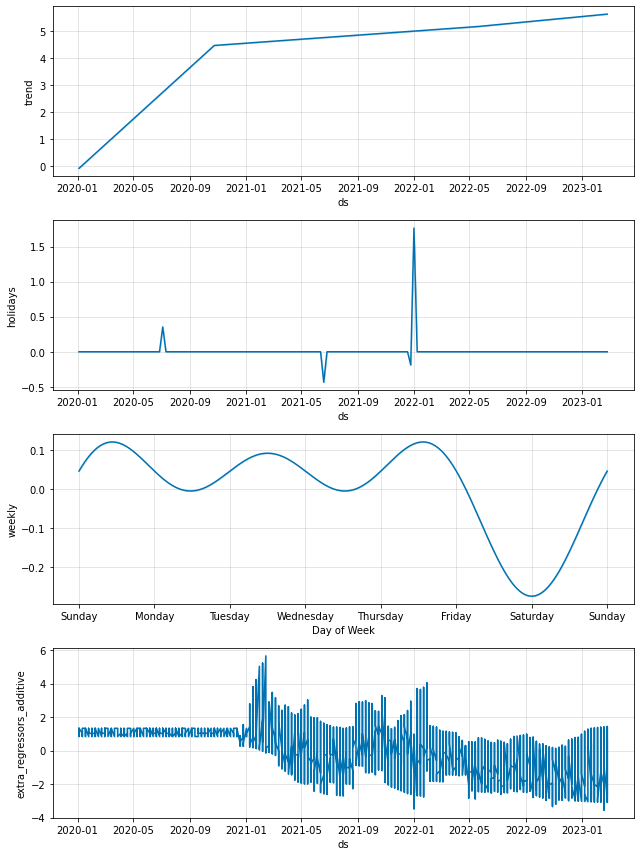

In [1417]:
# Create the time range for the forecast
future_multivariate = model.make_future_dataframe(periods = 60)
#for col in feature_list_copy:
#   future_multivariate[col] = multi_prophet[col]

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, multi_prophet[feature_list_copy], on='ds', how='inner')

# Make prediction
forecast_multivariate = model.predict(future_multivariate)
    
# Visualize the forecast
model.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

# Visualize the forecast components
model.plot_components(forecast_multivariate);

Training Set Metrics:
Training MAE: 167.99183329675475
Training MASE: 0.9559197906832824

Testing Set Metrics:
Testing MAE: 84.80228545029118
Testing MASE: 1.3882075412485846


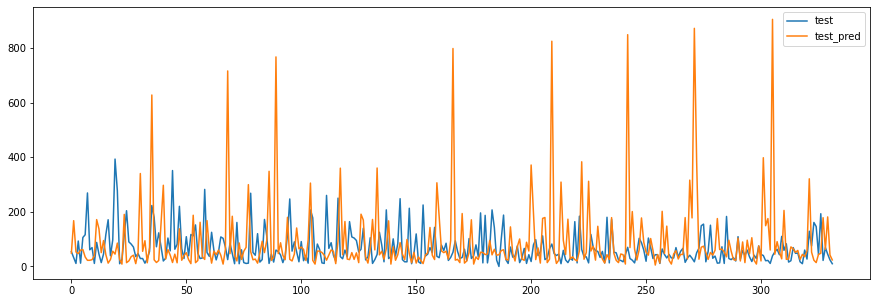

In [1434]:
test_pred=model.predict(test)
test_pred['yhat'] = np.expm1(test_pred['yhat'])

train_mae = mean_absolute_error(train.set_index('ds')['y'], train_pred.set_index('ds')['yhat'])
train_mase = MASE(train.set_index('ds')['y'], train_pred.set_index('ds')['yhat'])

print("Training Set Metrics:")
print("Training MAE:", train_mae)
print("Training MASE:", train_mase)


test_mae = mean_absolute_error(test.reset_index()['y'], test_pred['yhat'])
test_mase = MASE(test.reset_index()['y'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)

pd.concat([test.reset_index()['y'],test_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['test', 'test_pred'])
plt.show()

In [1435]:
model_multivariate = prophet.Prophet()

# Add regressor
for feature in correlated_list:
    model_multivariate.add_regressor(feature)

# Fit the model on the training dataset
model_multivariate.fit(train_log)

13:52:45 - cmdstanpy - INFO - Chain [1] start processing
13:53:41 - cmdstanpy - INFO - Chain [1] done processing



Testing Set Metrics:
Testing MAE: 63.697986078236035
Testing MASE: 1.0427316217554958


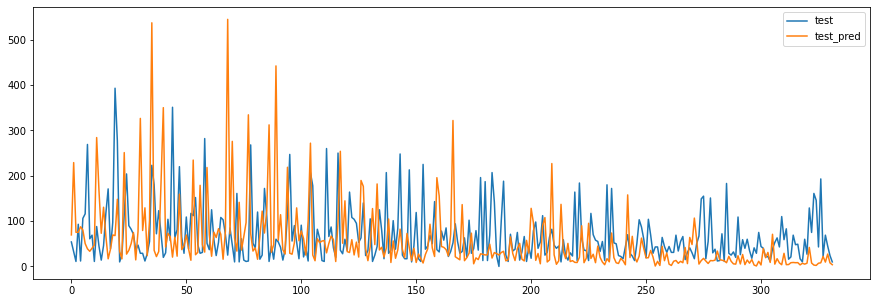

In [1437]:
test_pred=model_multivariate.predict(test)
test_pred['yhat'] = np.expm1(test_pred['yhat'])

test_mae = mean_absolute_error(test.reset_index()['y'], test_pred['yhat'])
test_mase = MASE(test.reset_index()['y'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)

pd.concat([test.reset_index()['y'],test_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['test', 'test_pred'])
plt.show()


Testing Set Metrics:
Testing MAE: 91.0149379385969
Testing MASE: 1.4899082323281687


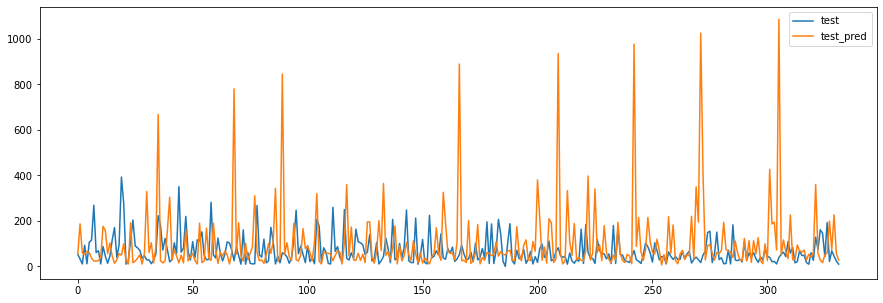

In [1441]:
test_pred=model_multivariate.predict(test)
test_pred['yhat'] = np.expm1(test_pred['yhat'])

test_mae = mean_absolute_error(test.reset_index()['y'], test_pred['yhat'])
test_mase = MASE(test.reset_index()['y'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)

pd.concat([test.reset_index()['y'],test_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['test', 'test_pred'])
plt.show()

In [1454]:
model_multivariate = prophet.Prophet()
model_multivariate.add_country_holidays(country_name='US')

# Add regressor
for feature in correlated_list:
    model_multivariate.add_regressor(feature)

# Fit the model on the training dataset
model_multivariate.fit(train_log)

14:18:46 - cmdstanpy - INFO - Chain [1] start processing
14:19:27 - cmdstanpy - INFO - Chain [1] done processing



Testing Set Metrics:
Testing MAE: 61.89864911486081
Testing MASE: 1.013276600248216


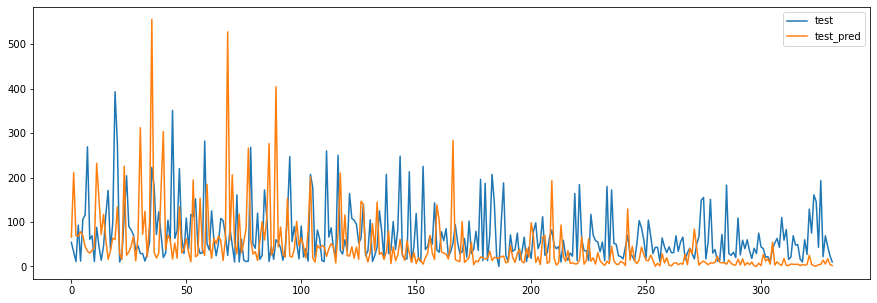

In [1455]:
test_pred=model_multivariate.predict(test)
test_pred['yhat'] = np.expm1(test_pred['yhat'])
#test_pred['yhat'] = test_pred['yhat'] * 0.7

test_mae = mean_absolute_error(test.reset_index()['y'], test_pred['yhat'])
test_mase = MASE(test.reset_index()['y'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)

pd.concat([test.reset_index()['y'],test_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['test', 'test_pred'])
plt.show()

In [1480]:
model_multivariate = prophet.Prophet(yearly_seasonality=False, weekly_seasonality=True, n_changepoints = 3)
model_multivariate.add_country_holidays(country_name='US')

for feature in feature_list:
    model_multivariate.add_regressor(feature)
    
model_multivariate.fit(train_log)

14:27:55 - cmdstanpy - INFO - Chain [1] start processing
14:28:07 - cmdstanpy - INFO - Chain [1] done processing


In [1483]:
test_pred['yhat']/2

0      19.028129
1      68.564692
2      24.324861
3      21.986594
4      31.571402
         ...    
327    85.318672
328    32.892638
329    67.873118
330    17.033706
331    10.873126
Name: yhat, Length: 332, dtype: float64


Testing Set Metrics:
Testing MAE: 66.44670670775331
Testing MASE: 1.087727988143736


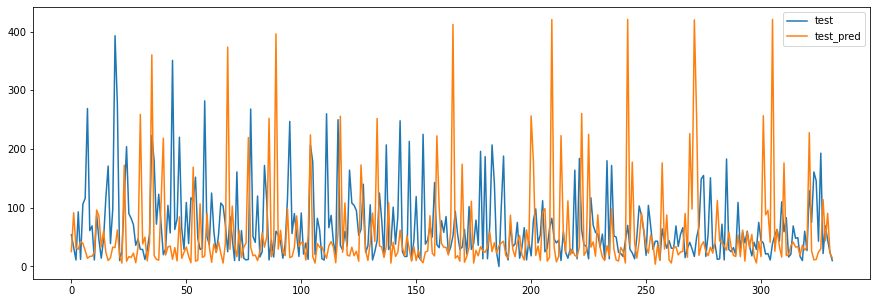

In [1485]:
test_pred=model_multivariate.predict(test)
test_pred['yhat'] = np.expm1(test_pred['yhat'])
test_pred['yhat'] = test_pred['yhat']/1.5

#test_pred['yhat'] = test_pred['yhat'] * 0.7

test_mae = mean_absolute_error(test.reset_index()['y'], test_pred['yhat'])
test_mase = MASE(test.reset_index()['y'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)

pd.concat([test.reset_index()['y'],test_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['test', 'test_pred'])
plt.show()

In [1494]:
model = prophet.Prophet()
model=model.fit(train_log)

14:36:55 - cmdstanpy - INFO - Chain [1] start processing
14:37:01 - cmdstanpy - INFO - Chain [1] done processing



Testing Set Metrics:
Testing MAE: 66.44670670775331
Testing MASE: 1.087727988143736


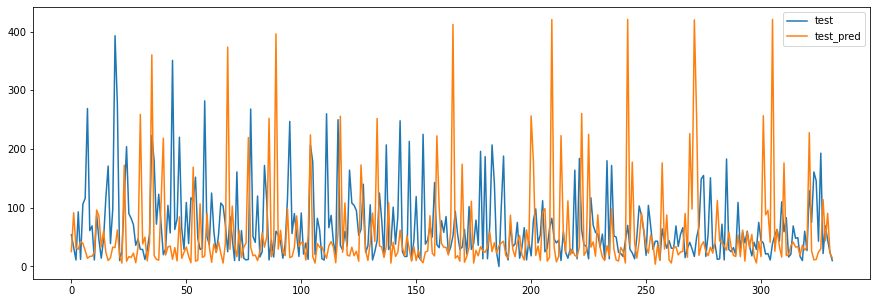

In [1495]:
test_pred=model.predict(test)
test_pred['yhat'] = np.expm1(test_pred['yhat'])
test_pred['yhat'] = test_pred['yhat']/1.5

#test_pred['yhat'] = test_pred['yhat'] * 0.7

test_mae = mean_absolute_error(test.reset_index()['y'], test_pred['yhat'])
test_mase = MASE(test.reset_index()['y'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)

pd.concat([test.reset_index()['y'],test_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['test', 'test_pred'])
plt.show()

In [1510]:
model = prophet.Prophet()
for col in train_log.columns:
    if col not in ['ds', 'y']:
        model.add_regressor(col)
model=model.fit(train_log)

14:42:39 - cmdstanpy - INFO - Chain [1] start processing
14:43:13 - cmdstanpy - INFO - Chain [1] done processing



Testing Set Metrics:
Testing MAE: 56.85445706196822
Testing MASE: 0.9307035255940396


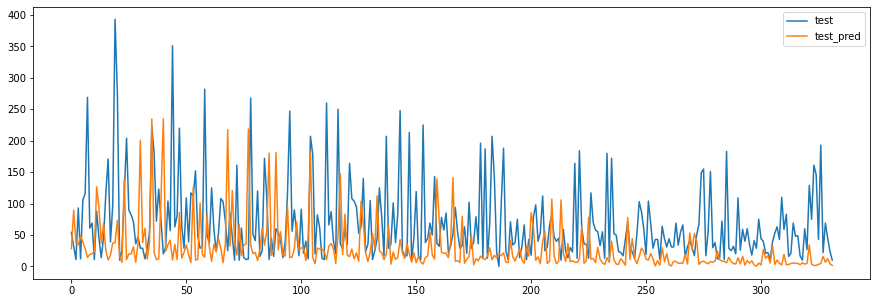

In [1516]:
test_pred=model.predict(test)
test_pred['yhat'] = np.expm1(test_pred['yhat'])

test_pred['yhat'] = test_pred['yhat'] * 0.5

test_mae = mean_absolute_error(test.reset_index()['y'], test_pred['yhat'])
test_mase = MASE(test.reset_index()['y'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)

pd.concat([test.reset_index()['y'],test_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['test', 'test_pred'])
plt.show()

In [1523]:
model = prophet.Prophet(n_changepoints = 3)
for col in train_log.columns:
    if col not in ['ds', 'y']:
        model.add_regressor(col)
model=model.fit(train_log)

14:45:31 - cmdstanpy - INFO - Chain [1] start processing
14:45:56 - cmdstanpy - INFO - Chain [1] done processing



Testing Set Metrics:
Testing MAE: 95.86105541705008
Testing MASE: 1.5692388399131343


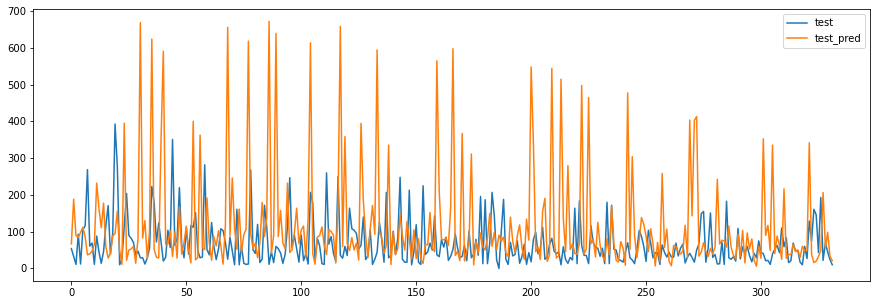

In [1525]:
test_pred=model.predict(test)
test_pred['yhat'] = np.expm1(test_pred['yhat'])

#test_pred['yhat'] = test_pred['yhat'] * 0.5

test_mae = mean_absolute_error(test.reset_index()['y'], test_pred['yhat'])
test_mase = MASE(test.reset_index()['y'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)

pd.concat([test.reset_index()['y'],test_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['test', 'test_pred'])
plt.show()

In [1521]:
model = prophet.Prophet(yearly_seasonality = False, n_changepoints = 3)
model.add_regressor('additional_doses')
model.add_regressor('distributed')
model.add_regressor('region_East')
model=model.fit(train_log)

14:45:18 - cmdstanpy - INFO - Chain [1] start processing
14:45:18 - cmdstanpy - INFO - Chain [1] done processing



Testing Set Metrics:
Testing MAE: 66.4797088342406
Testing MASE: 1.0882682306693192


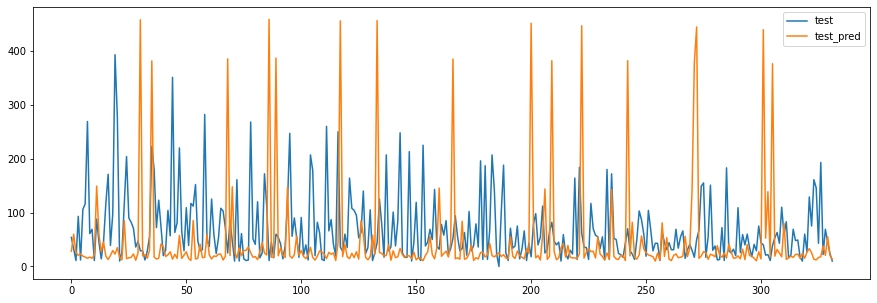

In [1522]:
test_pred=model.predict(test)
test_pred['yhat'] = np.expm1(test_pred['yhat'])

test_pred['yhat'] = test_pred['yhat'] * 0.7

test_mae = mean_absolute_error(test.reset_index()['y'], test_pred['yhat'])
test_mase = MASE(test.reset_index()['y'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)

pd.concat([test.reset_index()['y'],test_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['test', 'test_pred'])
plt.show()

In [1537]:
model = prophet.Prophet(yearly_seasonality = False)
model.add_regressor('additional_doses')
model.add_regressor('distributed')
model.add_regressor('region_East')
model=model.fit(train)

14:50:47 - cmdstanpy - INFO - Chain [1] start processing
14:50:50 - cmdstanpy - INFO - Chain [1] done processing



Testing Set Metrics:
Testing MAE: 104.5765047370269
Testing MASE: 1.7119101418375817


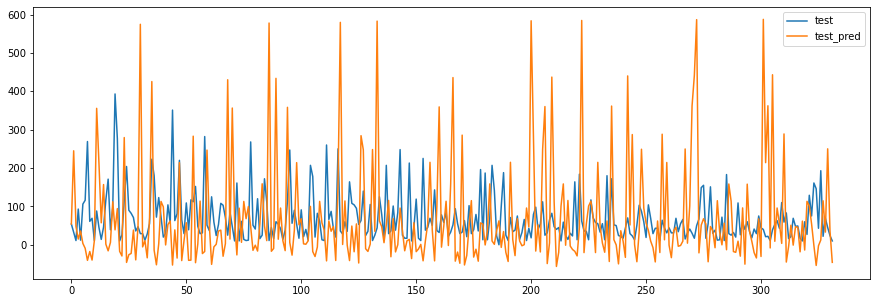

In [1538]:
test_pred=model.predict(test)
#test_pred['yhat'] = np.expm1(test_pred['yhat'])

#test_pred['yhat'] = test_pred['yhat'] * 0.7

test_mae = mean_absolute_error(test.reset_index()['y'], test_pred['yhat'])
test_mase = MASE(test.reset_index()['y'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)

pd.concat([test.reset_index()['y'],test_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['test', 'test_pred'])
plt.show()

### without seasonality

In [1029]:
# Add seasonality
model_multivariate = prophet.Prophet(n_changepoints = 3)

# Add regressor
for feature in feature_list:
    model_multivariate.add_regressor(feature)

# Fit the model on the training dataset
model_multivariate.fit(train_imputed)

15:00:43 - cmdstanpy - INFO - Chain [1] start processing
15:01:07 - cmdstanpy - INFO - Chain [1] done processing


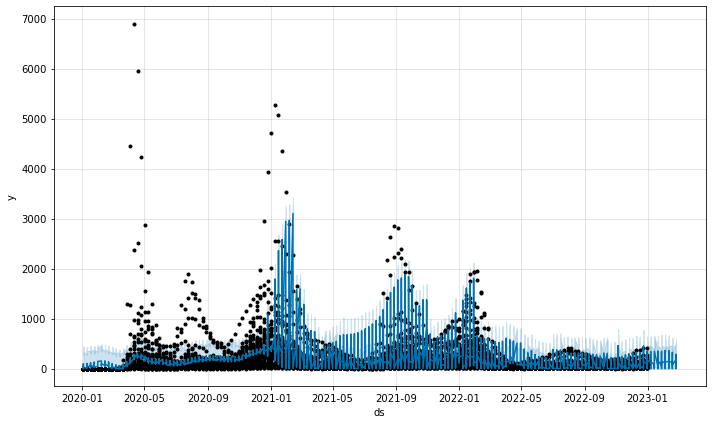

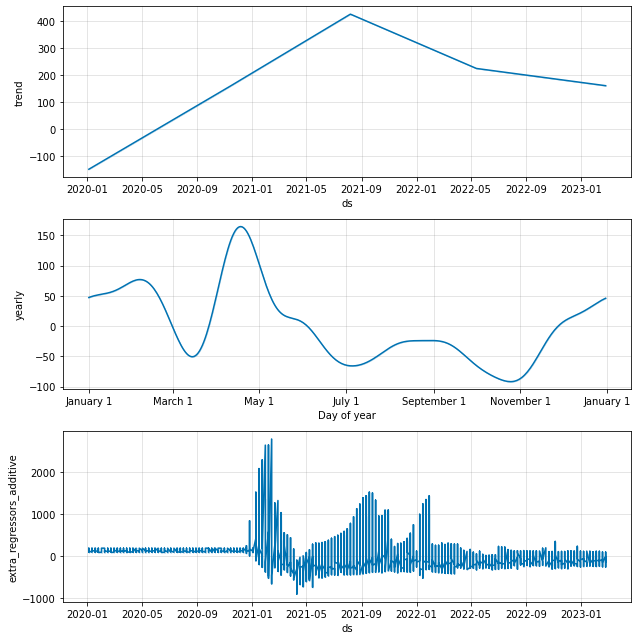

In [962]:
# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods = 60)

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, all_features_imputed[feature_list_copy], on='ds', how='inner')

# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_multivariate[col] = forecast_multivariate[col].clip(lower=0.0)
    
# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

# Visualize the forecast components
model_multivariate.plot_components(forecast_multivariate);

In [963]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-60:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MASE value
performance_multivariate_MASE = MASE(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MASE for the multivariate model is {performance_multivariate_MASE}')

The MAE for the multivariate model is 82.44729169258599
The MAPE for the multivariate model is 1.0005989286021528


In [1031]:
test_pred = model_multivariate.predict(test_imputed)

test_mae = mean_absolute_error(test.reset_index()['y'], test_pred['yhat'])
test_mase = MASE(test.reset_index()['y'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)


Testing Set Metrics:
Testing MAE: 97.96131515828489
Testing MASE: 1.000737546292253


### without change points

In [1032]:
# Add seasonality
model_multivariate = prophet.Prophet(yearly_seasonality = False, weekly_seasonality = True)
model_multivariate.add_country_holidays(country_name='US')

# Add regressor
for feature in feature_list:
    model_multivariate.add_regressor(feature)

# Fit the model on the training dataset
model_multivariate.fit(train_imputed)

15:01:26 - cmdstanpy - INFO - Chain [1] start processing
15:01:56 - cmdstanpy - INFO - Chain [1] done processing


In [974]:
# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods = 60)

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, all_features_imputed[feature_list_copy], on='ds', how='inner')

# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_multivariate[col] = forecast_multivariate[col].clip(lower=0.0)
    
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-60:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MASE value
performance_multivariate_MASE = MASE(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MASE for the multivariate model is {performance_multivariate_MASE}')

The MAE for the multivariate model is 66.18585072892988
The MASE for the multivariate model is 1.0006490101587273


In [1033]:
test_pred = model_multivariate.predict(test_imputed)

test_mae = mean_absolute_error(test.reset_index()['y'], test_pred['yhat'])
test_mase = MASE(test.reset_index()['y'], test_pred['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)


Testing Set Metrics:
Testing MAE: 82.86067668158026
Testing MASE: 0.999431306797041


### using regressors with the highest correlation

In [1157]:
# Set the correlation threshold
correlation_threshold = 0.05

# Create a correlation matrix
correlation_matrix = multi_prophet.corr()

# Extract the correlations with the target variable above the threshold
correlations_above_threshold = correlation_matrix['y'][correlation_matrix['y'].abs() > correlation_threshold]

# Sort the correlations in descending order
correlated_list = list(correlations_above_threshold.index)

In [1158]:
correlated_list.remove('y')

In [1159]:
# Add seasonality, holidays, and changepoints
model_multivariate = prophet.Prophet(yearly_seasonality = False, weekly_seasonality = True, n_changepoints = 2)
model_multivariate.add_country_holidays(country_name='US')

# Add regressor
for feature in correlated_list:
    model_multivariate.add_regressor(feature)

# Fit the model on the training dataset
model_multivariate.fit(train_imputed)

16:48:03 - cmdstanpy - INFO - Chain [1] start processing
16:48:23 - cmdstanpy - INFO - Chain [1] done processing


In [1160]:
test_pred=model_multivariate.predict(test_imputed)

test_mae = mean_absolute_error(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])
test_mase = MASE(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)


Testing Set Metrics:
Testing MAE: 78.56807158448673
Testing MASE: 0.024039966061803326


# Log

In [1263]:
train_imputed2 = train.fillna(10000000)
test_imputed2 = test.fillna(10000000)
train_imputed2['log_deaths'] = np.log1p(train_imputed2['y'])
test_imputed2['log_deaths'] = np.log1p(test_imputed2['y'])

In [1264]:
train_imputed2['log_deaths'] = np.log1p(train_imputed2['y'])
test_imputed2['log_deaths'] = np.log1p(test_imputed2['y'])

In [1265]:
train_log2 = train_imputed2.drop(['y'], axis = 1)
train_log2 = train_log2.rename(columns={'log_deaths':'y'})

test_log2 = test_imputed2.drop(['y'], axis = 1)
test_log2 = test_log2.rename(columns={'log_deaths':'y'})

In [1166]:
train_imputed['log_deaths'] = np.log1p(train['y'])
test_imputed['log_deaths'] = np.log1p(test['y'])

In [1173]:
train_log = train_imputed.drop(['y'], axis = 1)
train_log = train_log.rename(columns={'log_deaths':'y'})

test_log = test_imputed.drop(['y'], axis = 1)
test_log = test_log.rename(columns={'log_deaths':'y'})

In [1450]:
# Create and fit the Prophet model with log-transformed target variable
model = prophet.Prophet()

for feature in correlated_list:
    model.add_regressor(feature)

model = model.fit(train_log)

14:07:33 - cmdstanpy - INFO - Chain [1] start processing
14:08:31 - cmdstanpy - INFO - Chain [1] done processing


In [1451]:
# Make predictions on the test set
test_pred = model.predict(test_log)

# Apply inverse log transformation to get predictions in the original scale
test_pred['yhat'] = np.expm1(test_pred['yhat'])

# Test
test_mae = mean_absolute_error(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])
test_mase = MASE(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)


Testing Set Metrics:
Testing MAE: 63.697986078236035
Testing MASE: 1.0427316217554958


In [1177]:
model = prophet.Prophet(yearly_seasonality = False, weekly_seasonality = True, n_changepoints = 2)
model.add_country_holidays(country_name='US')

for feature in correlated_list:
    model.add_regressor(feature)
model = model.fit(train_log)

16:59:19 - cmdstanpy - INFO - Chain [1] start processing
16:59:28 - cmdstanpy - INFO - Chain [1] done processing


In [1178]:
# Make predictions on the test set
test_pred = model.predict(test_log)

# Apply inverse log transformation to get predictions in the original scale
test_pred['yhat'] = np.expm1(test_pred['yhat'])

# Test
test_mae = mean_absolute_error(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])
test_mase = MASE(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)


Testing Set Metrics:
Testing MAE: 69.5257023580683
Testing MASE: 0.024572864004920605


In [1181]:
model = prophet.Prophet(n_changepoints = 2)

for feature in correlated_list:
    model.add_regressor(feature)
model = model.fit(train_log)

10:00:18 - cmdstanpy - INFO - Chain [1] start processing
10:00:33 - cmdstanpy - INFO - Chain [1] done processing


In [1182]:
# Make predictions on the test set
test_pred = model.predict(test_log)

# Apply inverse log transformation to get predictions in the original scale
test_pred['yhat'] = np.expm1(test_pred['yhat'])

# Test
test_mae = mean_absolute_error(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])
test_mase = MASE(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)


Testing Set Metrics:
Testing MAE: 80.80172010483693
Testing MASE: 0.024813767679235387


In [1189]:
model = prophet.Prophet(yearly_seasonality = True, weekly_seasonality = True, n_changepoints = 2)
model.add_country_holidays(country_name='US')

for feature in correlated_list:
    model.add_regressor(feature)
model = model.fit(train_log)

10:06:06 - cmdstanpy - INFO - Chain [1] done processing
10:06:06 - cmdstanpy - INFO - Chain [1] done processing
10:06:06 - cmdstanpy - INFO - Chain [1] done processing
10:06:09 - cmdstanpy - INFO - Chain [1] done processing
10:06:11 - cmdstanpy - INFO - Chain [1] start processing
10:06:24 - cmdstanpy - INFO - Chain [1] done processing


In [1190]:
# Make predictions on the test set
test_pred = model.predict(test_log)

# Apply inverse log transformation to get predictions in the original scale
test_pred['yhat'] = np.expm1(test_pred['yhat'])

# Test
test_mae = mean_absolute_error(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])
test_mase = MASE(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)


Testing Set Metrics:
Testing MAE: 89.9265859049615
Testing MASE: 0.024717548653703094


In [1191]:
model = prophet.Prophet(yearly_seasonality = True, weekly_seasonality = True)
model.add_country_holidays(country_name='US')

for feature in correlated_list:
    model.add_regressor(feature)
model = model.fit(train_log)

10:06:33 - cmdstanpy - INFO - Chain [1] start processing
10:07:13 - cmdstanpy - INFO - Chain [1] done processing


In [1192]:
# Make predictions on the test set
test_pred = model.predict(test_log)

# Apply inverse log transformation to get predictions in the original scale
test_pred['yhat'] = np.expm1(test_pred['yhat'])

# Test
test_mae = mean_absolute_error(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])
test_mase = MASE(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)


Testing Set Metrics:
Testing MAE: 60.15840613159734
Testing MASE: 0.0246541455841075


# Cross Validation

In [1057]:
train.shape

(6974, 107)

In [1193]:
model = prophet.Prophet(yearly_seasonality = True, weekly_seasonality = True)
model.add_country_holidays(country_name='US')

for feature in correlated_list:
    model.add_regressor(feature)
model = model.fit(train_log)

10:07:39 - cmdstanpy - INFO - Chain [1] start processing
10:08:20 - cmdstanpy - INFO - Chain [1] done processing


In [1194]:
from prophet.diagnostics import cross_validation

data_cv = cross_validation(model, initial='720 days', period='20 days', horizon = '30 days', parallel="processes")
data_cv.head()

10:08:44 - cmdstanpy - INFO - Chain [1] start processing
10:08:45 - cmdstanpy - INFO - Chain [1] start processing
10:08:45 - cmdstanpy - INFO - Chain [1] start processing
10:08:45 - cmdstanpy - INFO - Chain [1] start processing
10:09:11 - cmdstanpy - INFO - Chain [1] done processing
10:09:16 - cmdstanpy - INFO - Chain [1] done processing
10:09:19 - cmdstanpy - INFO - Chain [1] done processing
10:09:19 - cmdstanpy - INFO - Chain [1] start processing
10:09:26 - cmdstanpy - INFO - Chain [1] start processing
10:09:29 - cmdstanpy - INFO - Chain [1] start processing
10:09:30 - cmdstanpy - INFO - Chain [1] done processing
10:09:38 - cmdstanpy - INFO - Chain [1] start processing
10:10:06 - cmdstanpy - INFO - Chain [1] done processing
10:10:16 - cmdstanpy - INFO - Chain [1] start processing
10:10:19 - cmdstanpy - INFO - Chain [1] done processing
10:10:28 - cmdstanpy - INFO - Chain [1] start processing
10:10:30 - cmdstanpy - INFO - Chain [1] done processing
10:10:40 - cmdstanpy - INFO - Chain [1

KeyboardInterrupt: 

In [1195]:
from prophet.diagnostics import performance_metrics

# Model performance metrics
data_p = performance_metrics(data_cv)
data_p.head()

horizon           mse        rmse         mae     mdape     smape  coverage
0  3 days  37206.561976  192.890026  103.245018  0.881274  1.048456  0.973344
1  4 days  19199.798791  138.563339   81.245128  0.823275  0.980523  0.985857
2  5 days   9099.300981   95.390256   59.926640  0.664259  0.842306  0.993967
3  6 days  16261.957247  127.522379   84.073321  0.948538  1.036195  0.994012
4  7 days  53112.082007  230.460587  133.446741  1.010448  1.331428  0.964072

In [1196]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  

# Use cross validation to evaluate all parameters
for params in all_params:
    m = prophet.Prophet(**params).fit(train_log)  # Fit model with given params
    df_cv = cross_validation(m, initial='720 days', period='20 days', horizon = '30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
print(tuning_results)

10:13:38 - cmdstanpy - INFO - Chain [1] start processing
10:13:38 - cmdstanpy - INFO - Chain [1] done processing
10:13:48 - cmdstanpy - INFO - Chain [1] start processing
10:13:48 - cmdstanpy - INFO - Chain [1] start processing
10:13:48 - cmdstanpy - INFO - Chain [1] start processing
10:13:48 - cmdstanpy - INFO - Chain [1] start processing
10:13:50 - cmdstanpy - INFO - Chain [1] done processing
10:13:50 - cmdstanpy - INFO - Chain [1] done processing
10:13:51 - cmdstanpy - INFO - Chain [1] done processing
10:13:52 - cmdstanpy - INFO - Chain [1] done processing
10:13:52 - cmdstanpy - INFO - Chain [1] start processing
10:13:53 - cmdstanpy - INFO - Chain [1] start processing
10:13:54 - cmdstanpy - INFO - Chain [1] done processing
10:13:54 - cmdstanpy - INFO - Chain [1] done processing
10:13:54 - cmdstanpy - INFO - Chain [1] start processing
10:13:55 - cmdstanpy - INFO - Chain [1] start processing
10:13:56 - cmdstanpy - INFO - Chain [1] done processing
10:13:56 - cmdstanpy - INFO - Chain [1]

10:15:25 - cmdstanpy - INFO - Chain [1] start processing
10:15:26 - cmdstanpy - INFO - Chain [1] start processing
10:15:26 - cmdstanpy - INFO - Chain [1] done processing
10:15:27 - cmdstanpy - INFO - Chain [1] done processing
10:15:27 - cmdstanpy - INFO - Chain [1] done processing
10:15:27 - cmdstanpy - INFO - Chain [1] start processing
10:15:27 - cmdstanpy - INFO - Chain [1] done processing
10:15:28 - cmdstanpy - INFO - Chain [1] start processing
10:15:29 - cmdstanpy - INFO - Chain [1] done processing
10:15:37 - cmdstanpy - INFO - Chain [1] start processing
10:15:37 - cmdstanpy - INFO - Chain [1] start processing
10:15:37 - cmdstanpy - INFO - Chain [1] start processing
10:15:38 - cmdstanpy - INFO - Chain [1] start processing
10:15:38 - cmdstanpy - INFO - Chain [1] done processing
10:15:38 - cmdstanpy - INFO - Chain [1] done processing
10:15:39 - cmdstanpy - INFO - Chain [1] done processing
10:15:39 - cmdstanpy - INFO - Chain [1] done processing
10:15:40 - cmdstanpy - INFO - Chain [1] 

10:17:15 - cmdstanpy - INFO - Chain [1] start processing
10:17:15 - cmdstanpy - INFO - Chain [1] done processing
10:17:16 - cmdstanpy - INFO - Chain [1] done processing
10:17:16 - cmdstanpy - INFO - Chain [1] done processing
10:17:16 - cmdstanpy - INFO - Chain [1] start processing
10:17:17 - cmdstanpy - INFO - Chain [1] start processing
10:17:17 - cmdstanpy - INFO - Chain [1] done processing
10:17:18 - cmdstanpy - INFO - Chain [1] start processing
10:17:18 - cmdstanpy - INFO - Chain [1] start processing
10:17:19 - cmdstanpy - INFO - Chain [1] done processing
10:17:19 - cmdstanpy - INFO - Chain [1] done processing
10:17:19 - cmdstanpy - INFO - Chain [1] start processing
10:17:19 - cmdstanpy - INFO - Chain [1] done processing
10:17:21 - cmdstanpy - INFO - Chain [1] done processing
10:17:23 - cmdstanpy - INFO - Chain [1] start processing
10:17:24 - cmdstanpy - INFO - Chain [1] done processing
10:17:35 - cmdstanpy - INFO - Chain [1] start processing
10:17:35 - cmdstanpy - INFO - Chain [1] 

10:19:34 - cmdstanpy - INFO - Chain [1] start processing
10:19:34 - cmdstanpy - INFO - Chain [1] start processing
10:19:34 - cmdstanpy - INFO - Chain [1] start processing
10:19:35 - cmdstanpy - INFO - Chain [1] start processing
10:19:36 - cmdstanpy - INFO - Chain [1] done processing
10:19:36 - cmdstanpy - INFO - Chain [1] done processing
10:19:36 - cmdstanpy - INFO - Chain [1] done processing
10:19:37 - cmdstanpy - INFO - Chain [1] done processing
10:19:37 - cmdstanpy - INFO - Chain [1] start processing
10:19:37 - cmdstanpy - INFO - Chain [1] start processing
10:19:38 - cmdstanpy - INFO - Chain [1] start processing
10:19:38 - cmdstanpy - INFO - Chain [1] start processing
10:19:39 - cmdstanpy - INFO - Chain [1] done processing
10:19:39 - cmdstanpy - INFO - Chain [1] done processing
10:19:40 - cmdstanpy - INFO - Chain [1] done processing
10:19:40 - cmdstanpy - INFO - Chain [1] done processing
10:19:41 - cmdstanpy - INFO - Chain [1] start processing
10:19:41 - cmdstanpy - INFO - Chain [1]

10:21:14 - cmdstanpy - INFO - Chain [1] start processing
10:21:14 - cmdstanpy - INFO - Chain [1] done processing
10:21:14 - cmdstanpy - INFO - Chain [1] done processing
10:21:15 - cmdstanpy - INFO - Chain [1] done processing
10:21:16 - cmdstanpy - INFO - Chain [1] done processing
10:21:17 - cmdstanpy - INFO - Chain [1] start processing
10:21:17 - cmdstanpy - INFO - Chain [1] start processing
10:21:17 - cmdstanpy - INFO - Chain [1] start processing
10:21:18 - cmdstanpy - INFO - Chain [1] start processing
10:21:19 - cmdstanpy - INFO - Chain [1] done processing
10:21:19 - cmdstanpy - INFO - Chain [1] done processing
10:21:19 - cmdstanpy - INFO - Chain [1] done processing
10:21:20 - cmdstanpy - INFO - Chain [1] done processing
10:21:21 - cmdstanpy - INFO - Chain [1] start processing
10:21:21 - cmdstanpy - INFO - Chain [1] start processing
10:21:21 - cmdstanpy - INFO - Chain [1] start processing
10:21:22 - cmdstanpy - INFO - Chain [1] start processing
10:21:23 - cmdstanpy - INFO - Chain [1]

10:23:03 - cmdstanpy - INFO - Chain [1] done processing
10:23:03 - cmdstanpy - INFO - Chain [1] done processing
10:23:04 - cmdstanpy - INFO - Chain [1] done processing
10:23:04 - cmdstanpy - INFO - Chain [1] done processing
10:23:04 - cmdstanpy - INFO - Chain [1] start processing
10:23:05 - cmdstanpy - INFO - Chain [1] start processing
10:23:05 - cmdstanpy - INFO - Chain [1] start processing
10:23:05 - cmdstanpy - INFO - Chain [1] done processing
10:23:06 - cmdstanpy - INFO - Chain [1] start processing
10:23:06 - cmdstanpy - INFO - Chain [1] done processing
10:23:06 - cmdstanpy - INFO - Chain [1] done processing
10:23:06 - cmdstanpy - INFO - Chain [1] done processing
10:23:07 - cmdstanpy - INFO - Chain [1] start processing
10:23:07 - cmdstanpy - INFO - Chain [1] start processing
10:23:08 - cmdstanpy - INFO - Chain [1] done processing
10:23:08 - cmdstanpy - INFO - Chain [1] start processing
10:23:08 - cmdstanpy - INFO - Chain [1] start processing
10:23:09 - cmdstanpy - INFO - Chain [1] 

10:24:38 - cmdstanpy - INFO - Chain [1] start processing
10:24:39 - cmdstanpy - INFO - Chain [1] done processing
10:24:47 - cmdstanpy - INFO - Chain [1] start processing
10:24:47 - cmdstanpy - INFO - Chain [1] start processing
10:24:47 - cmdstanpy - INFO - Chain [1] start processing
10:24:48 - cmdstanpy - INFO - Chain [1] start processing
10:24:48 - cmdstanpy - INFO - Chain [1] done processing
10:24:49 - cmdstanpy - INFO - Chain [1] done processing
10:24:49 - cmdstanpy - INFO - Chain [1] done processing
10:24:50 - cmdstanpy - INFO - Chain [1] done processing
10:24:50 - cmdstanpy - INFO - Chain [1] start processing
10:24:50 - cmdstanpy - INFO - Chain [1] start processing
10:24:50 - cmdstanpy - INFO - Chain [1] start processing
10:24:51 - cmdstanpy - INFO - Chain [1] done processing
10:24:51 - cmdstanpy - INFO - Chain [1] start processing
10:24:51 - cmdstanpy - INFO - Chain [1] done processing
10:24:52 - cmdstanpy - INFO - Chain [1] done processing
10:24:52 - cmdstanpy - INFO - Chain [1]

10:26:08 - cmdstanpy - INFO - Chain [1] done processing
10:26:08 - cmdstanpy - INFO - Chain [1] done processing
10:26:09 - cmdstanpy - INFO - Chain [1] done processing
10:26:09 - cmdstanpy - INFO - Chain [1] start processing
10:26:10 - cmdstanpy - INFO - Chain [1] start processing
10:26:10 - cmdstanpy - INFO - Chain [1] done processing
10:26:11 - cmdstanpy - INFO - Chain [1] done processing
10:26:12 - cmdstanpy - INFO - Chain [1] start processing
10:26:13 - cmdstanpy - INFO - Chain [1] done processing
10:26:21 - cmdstanpy - INFO - Chain [1] start processing
10:26:21 - cmdstanpy - INFO - Chain [1] start processing
10:26:21 - cmdstanpy - INFO - Chain [1] start processing
10:26:21 - cmdstanpy - INFO - Chain [1] start processing
10:26:22 - cmdstanpy - INFO - Chain [1] done processing
10:26:22 - cmdstanpy - INFO - Chain [1] done processing
10:26:23 - cmdstanpy - INFO - Chain [1] done processing
10:26:23 - cmdstanpy - INFO - Chain [1] done processing
10:26:23 - cmdstanpy - INFO - Chain [1] s

10:27:39 - cmdstanpy - INFO - Chain [1] done processing
10:27:40 - cmdstanpy - INFO - Chain [1] start processing
10:27:40 - cmdstanpy - INFO - Chain [1] start processing
10:27:40 - cmdstanpy - INFO - Chain [1] start processing
10:27:40 - cmdstanpy - INFO - Chain [1] start processing
10:27:41 - cmdstanpy - INFO - Chain [1] done processing
10:27:42 - cmdstanpy - INFO - Chain [1] done processing
10:27:42 - cmdstanpy - INFO - Chain [1] done processing
10:27:43 - cmdstanpy - INFO - Chain [1] done processing
10:27:43 - cmdstanpy - INFO - Chain [1] start processing
10:27:43 - cmdstanpy - INFO - Chain [1] start processing
10:27:44 - cmdstanpy - INFO - Chain [1] done processing
10:27:44 - cmdstanpy - INFO - Chain [1] done processing
10:27:46 - cmdstanpy - INFO - Chain [1] start processing
10:27:46 - cmdstanpy - INFO - Chain [1] done processing
10:27:55 - cmdstanpy - INFO - Chain [1] start processing
10:27:55 - cmdstanpy - INFO - Chain [1] start processing
10:27:55 - cmdstanpy - INFO - Chain [1]

10:29:26 - cmdstanpy - INFO - Chain [1] done processing
10:29:27 - cmdstanpy - INFO - Chain [1] start processing
10:29:27 - cmdstanpy - INFO - Chain [1] done processing
10:29:27 - cmdstanpy - INFO - Chain [1] done processing
10:29:28 - cmdstanpy - INFO - Chain [1] start processing
10:29:29 - cmdstanpy - INFO - Chain [1] start processing
10:29:29 - cmdstanpy - INFO - Chain [1] start processing
10:29:30 - cmdstanpy - INFO - Chain [1] done processing
10:29:31 - cmdstanpy - INFO - Chain [1] done processing
10:29:31 - cmdstanpy - INFO - Chain [1] done processing
10:29:32 - cmdstanpy - INFO - Chain [1] start processing
10:29:33 - cmdstanpy - INFO - Chain [1] done processing
10:29:33 - cmdstanpy - INFO - Chain [1] start processing
10:29:33 - cmdstanpy - INFO - Chain [1] start processing
10:29:34 - cmdstanpy - INFO - Chain [1] done processing
10:29:34 - cmdstanpy - INFO - Chain [1] start processing
10:29:35 - cmdstanpy - INFO - Chain [1] done processing
10:29:35 - cmdstanpy - INFO - Chain [1] 

10:31:17 - cmdstanpy - INFO - Chain [1] done processing
10:31:17 - cmdstanpy - INFO - Chain [1] start processing
10:31:18 - cmdstanpy - INFO - Chain [1] done processing
10:31:18 - cmdstanpy - INFO - Chain [1] start processing
10:31:19 - cmdstanpy - INFO - Chain [1] start processing
10:31:19 - cmdstanpy - INFO - Chain [1] done processing
10:31:20 - cmdstanpy - INFO - Chain [1] start processing
10:31:20 - cmdstanpy - INFO - Chain [1] done processing
10:31:20 - cmdstanpy - INFO - Chain [1] done processing
10:31:20 - cmdstanpy - INFO - Chain [1] start processing
10:31:21 - cmdstanpy - INFO - Chain [1] start processing
10:31:21 - cmdstanpy - INFO - Chain [1] start processing
10:31:23 - cmdstanpy - INFO - Chain [1] done processing
10:31:24 - cmdstanpy - INFO - Chain [1] done processing
10:31:24 - cmdstanpy - INFO - Chain [1] done processing
10:31:25 - cmdstanpy - INFO - Chain [1] start processing
10:31:25 - cmdstanpy - INFO - Chain [1] done processing
10:31:26 - cmdstanpy - INFO - Chain [1] 

10:33:06 - cmdstanpy - INFO - Chain [1] done processing
10:33:06 - cmdstanpy - INFO - Chain [1] start processing
10:33:06 - cmdstanpy - INFO - Chain [1] start processing
10:33:07 - cmdstanpy - INFO - Chain [1] start processing
10:33:07 - cmdstanpy - INFO - Chain [1] start processing
10:33:08 - cmdstanpy - INFO - Chain [1] done processing
10:33:08 - cmdstanpy - INFO - Chain [1] done processing
10:33:09 - cmdstanpy - INFO - Chain [1] done processing
10:33:09 - cmdstanpy - INFO - Chain [1] done processing
10:33:10 - cmdstanpy - INFO - Chain [1] start processing
10:33:10 - cmdstanpy - INFO - Chain [1] start processing
10:33:10 - cmdstanpy - INFO - Chain [1] start processing
10:33:11 - cmdstanpy - INFO - Chain [1] done processing
10:33:11 - cmdstanpy - INFO - Chain [1] start processing
10:33:12 - cmdstanpy - INFO - Chain [1] done processing
10:33:12 - cmdstanpy - INFO - Chain [1] done processing
10:33:12 - cmdstanpy - INFO - Chain [1] done processing
10:33:13 - cmdstanpy - INFO - Chain [1] 

10:34:58 - cmdstanpy - INFO - Chain [1] done processing
10:34:59 - cmdstanpy - INFO - Chain [1] done processing
10:34:59 - cmdstanpy - INFO - Chain [1] done processing
10:35:00 - cmdstanpy - INFO - Chain [1] done processing
10:35:00 - cmdstanpy - INFO - Chain [1] start processing
10:35:00 - cmdstanpy - INFO - Chain [1] start processing
10:35:01 - cmdstanpy - INFO - Chain [1] start processing
10:35:01 - cmdstanpy - INFO - Chain [1] start processing
10:35:02 - cmdstanpy - INFO - Chain [1] done processing
10:35:02 - cmdstanpy - INFO - Chain [1] done processing
10:35:03 - cmdstanpy - INFO - Chain [1] done processing
10:35:03 - cmdstanpy - INFO - Chain [1] done processing
10:35:04 - cmdstanpy - INFO - Chain [1] start processing
10:35:04 - cmdstanpy - INFO - Chain [1] start processing
10:35:05 - cmdstanpy - INFO - Chain [1] start processing
10:35:05 - cmdstanpy - INFO - Chain [1] done processing
10:35:05 - cmdstanpy - INFO - Chain [1] start processing
10:35:06 - cmdstanpy - INFO - Chain [1] 

10:36:49 - cmdstanpy - INFO - Chain [1] start processing
10:36:51 - cmdstanpy - INFO - Chain [1] done processing
10:37:04 - cmdstanpy - INFO - Chain [1] start processing
10:37:04 - cmdstanpy - INFO - Chain [1] start processing
10:37:04 - cmdstanpy - INFO - Chain [1] start processing
10:37:04 - cmdstanpy - INFO - Chain [1] start processing
10:37:06 - cmdstanpy - INFO - Chain [1] done processing
10:37:06 - cmdstanpy - INFO - Chain [1] done processing
10:37:07 - cmdstanpy - INFO - Chain [1] done processing
10:37:08 - cmdstanpy - INFO - Chain [1] done processing
10:37:08 - cmdstanpy - INFO - Chain [1] start processing
10:37:08 - cmdstanpy - INFO - Chain [1] start processing
10:37:09 - cmdstanpy - INFO - Chain [1] start processing
10:37:09 - cmdstanpy - INFO - Chain [1] done processing
10:37:10 - cmdstanpy - INFO - Chain [1] start processing
10:37:10 - cmdstanpy - INFO - Chain [1] done processing
10:37:11 - cmdstanpy - INFO - Chain [1] done processing
10:37:11 - cmdstanpy - INFO - Chain [1]

10:38:56 - cmdstanpy - INFO - Chain [1] done processing
10:38:56 - cmdstanpy - INFO - Chain [1] done processing
10:38:57 - cmdstanpy - INFO - Chain [1] start processing
10:38:57 - cmdstanpy - INFO - Chain [1] done processing
10:38:58 - cmdstanpy - INFO - Chain [1] start processing
10:38:59 - cmdstanpy - INFO - Chain [1] done processing
10:38:59 - cmdstanpy - INFO - Chain [1] done processing
10:39:01 - cmdstanpy - INFO - Chain [1] start processing
10:39:03 - cmdstanpy - INFO - Chain [1] done processing
10:39:16 - cmdstanpy - INFO - Chain [1] start processing
10:39:16 - cmdstanpy - INFO - Chain [1] start processing
10:39:16 - cmdstanpy - INFO - Chain [1] start processing
10:39:16 - cmdstanpy - INFO - Chain [1] start processing
10:39:19 - cmdstanpy - INFO - Chain [1] done processing
10:39:19 - cmdstanpy - INFO - Chain [1] done processing
10:39:20 - cmdstanpy - INFO - Chain [1] done processing
10:39:20 - cmdstanpy - INFO - Chain [1] done processing
10:39:20 - cmdstanpy - INFO - Chain [1] s

10:41:02 - cmdstanpy - INFO - Chain [1] start processing
10:41:02 - cmdstanpy - INFO - Chain [1] done processing
10:41:02 - cmdstanpy - INFO - Chain [1] start processing
10:41:03 - cmdstanpy - INFO - Chain [1] start processing
10:41:03 - cmdstanpy - INFO - Chain [1] done processing
10:41:04 - cmdstanpy - INFO - Chain [1] start processing
10:41:04 - cmdstanpy - INFO - Chain [1] done processing
10:41:04 - cmdstanpy - INFO - Chain [1] done processing
10:41:05 - cmdstanpy - INFO - Chain [1] start processing
10:41:05 - cmdstanpy - INFO - Chain [1] done processing
10:41:06 - cmdstanpy - INFO - Chain [1] start processing
10:41:07 - cmdstanpy - INFO - Chain [1] done processing
10:41:07 - cmdstanpy - INFO - Chain [1] done processing
10:41:08 - cmdstanpy - INFO - Chain [1] start processing
10:41:10 - cmdstanpy - INFO - Chain [1] done processing
10:41:19 - cmdstanpy - INFO - Chain [1] start processing
10:41:19 - cmdstanpy - INFO - Chain [1] start processing
10:41:19 - cmdstanpy - INFO - Chain [1]

10:43:02 - cmdstanpy - INFO - Chain [1] start processing
10:43:03 - cmdstanpy - INFO - Chain [1] start processing
10:43:04 - cmdstanpy - INFO - Chain [1] done processing
10:43:05 - cmdstanpy - INFO - Chain [1] done processing
10:43:05 - cmdstanpy - INFO - Chain [1] done processing
10:43:06 - cmdstanpy - INFO - Chain [1] done processing
10:43:06 - cmdstanpy - INFO - Chain [1] start processing
10:43:06 - cmdstanpy - INFO - Chain [1] start processing
10:43:07 - cmdstanpy - INFO - Chain [1] start processing
10:43:08 - cmdstanpy - INFO - Chain [1] done processing
10:43:08 - cmdstanpy - INFO - Chain [1] start processing
10:43:08 - cmdstanpy - INFO - Chain [1] done processing
10:43:09 - cmdstanpy - INFO - Chain [1] done processing
10:43:10 - cmdstanpy - INFO - Chain [1] done processing
10:43:10 - cmdstanpy - INFO - Chain [1] start processing
10:43:10 - cmdstanpy - INFO - Chain [1] start processing
10:43:11 - cmdstanpy - INFO - Chain [1] done processing
10:43:11 - cmdstanpy - INFO - Chain [1] 

10:45:32 - cmdstanpy - INFO - Chain [1] start processing
10:45:35 - cmdstanpy - INFO - Chain [1] done processing
10:45:37 - cmdstanpy - INFO - Chain [1] start processing
10:45:37 - cmdstanpy - INFO - Chain [1] done processing
10:45:38 - cmdstanpy - INFO - Chain [1] done processing
10:45:39 - cmdstanpy - INFO - Chain [1] start processing
10:45:39 - cmdstanpy - INFO - Chain [1] done processing
10:45:41 - cmdstanpy - INFO - Chain [1] start processing
10:45:41 - cmdstanpy - INFO - Chain [1] start processing
10:45:43 - cmdstanpy - INFO - Chain [1] done processing
10:45:45 - cmdstanpy - INFO - Chain [1] start processing
10:45:45 - cmdstanpy - INFO - Chain [1] done processing
10:45:45 - cmdstanpy - INFO - Chain [1] done processing
10:45:46 - cmdstanpy - INFO - Chain [1] done processing
10:45:47 - cmdstanpy - INFO - Chain [1] start processing
10:45:47 - cmdstanpy - INFO - Chain [1] start processing
10:45:48 - cmdstanpy - INFO - Chain [1] start processing
10:45:50 - cmdstanpy - INFO - Chain [1]

10:49:05 - cmdstanpy - INFO - Chain [1] done processing
10:49:06 - cmdstanpy - INFO - Chain [1] done processing
10:49:07 - cmdstanpy - INFO - Chain [1] start processing
10:49:07 - cmdstanpy - INFO - Chain [1] done processing
10:49:08 - cmdstanpy - INFO - Chain [1] done processing
10:49:08 - cmdstanpy - INFO - Chain [1] start processing
10:49:09 - cmdstanpy - INFO - Chain [1] start processing
10:49:10 - cmdstanpy - INFO - Chain [1] start processing
10:49:12 - cmdstanpy - INFO - Chain [1] done processing
10:49:14 - cmdstanpy - INFO - Chain [1] done processing
10:49:14 - cmdstanpy - INFO - Chain [1] start processing
10:49:15 - cmdstanpy - INFO - Chain [1] done processing
10:49:16 - cmdstanpy - INFO - Chain [1] done processing
10:49:16 - cmdstanpy - INFO - Chain [1] start processing
10:49:17 - cmdstanpy - INFO - Chain [1] start processing
10:49:18 - cmdstanpy - INFO - Chain [1] start processing
10:49:19 - cmdstanpy - INFO - Chain [1] done processing
10:49:21 - cmdstanpy - INFO - Chain [1] 

10:52:23 - cmdstanpy - INFO - Chain [1] start processing
10:52:26 - cmdstanpy - INFO - Chain [1] done processing
10:52:35 - cmdstanpy - INFO - Chain [1] start processing
10:52:35 - cmdstanpy - INFO - Chain [1] start processing
10:52:35 - cmdstanpy - INFO - Chain [1] start processing
10:52:35 - cmdstanpy - INFO - Chain [1] start processing
10:52:39 - cmdstanpy - INFO - Chain [1] done processing
10:52:39 - cmdstanpy - INFO - Chain [1] done processing
10:52:40 - cmdstanpy - INFO - Chain [1] done processing
10:52:40 - cmdstanpy - INFO - Chain [1] done processing
10:52:41 - cmdstanpy - INFO - Chain [1] start processing
10:52:41 - cmdstanpy - INFO - Chain [1] start processing
10:52:41 - cmdstanpy - INFO - Chain [1] start processing
10:52:41 - cmdstanpy - INFO - Chain [1] start processing
10:52:44 - cmdstanpy - INFO - Chain [1] done processing
10:52:46 - cmdstanpy - INFO - Chain [1] done processing
10:52:47 - cmdstanpy - INFO - Chain [1] start processing
10:52:47 - cmdstanpy - INFO - Chain [1

10:55:48 - cmdstanpy - INFO - Chain [1] start processing
10:55:48 - cmdstanpy - INFO - Chain [1] done processing
10:55:50 - cmdstanpy - INFO - Chain [1] start processing
10:55:53 - cmdstanpy - INFO - Chain [1] done processing
10:55:53 - cmdstanpy - INFO - Chain [1] done processing
10:55:56 - cmdstanpy - INFO - Chain [1] done processing
10:55:57 - cmdstanpy - INFO - Chain [1] done processing
10:55:58 - cmdstanpy - INFO - Chain [1] start processing
10:56:02 - cmdstanpy - INFO - Chain [1] done processing
10:56:12 - cmdstanpy - INFO - Chain [1] start processing
10:56:12 - cmdstanpy - INFO - Chain [1] start processing
10:56:12 - cmdstanpy - INFO - Chain [1] start processing
10:56:12 - cmdstanpy - INFO - Chain [1] start processing
10:56:16 - cmdstanpy - INFO - Chain [1] done processing
10:56:16 - cmdstanpy - INFO - Chain [1] done processing
10:56:17 - cmdstanpy - INFO - Chain [1] done processing
10:56:17 - cmdstanpy - INFO - Chain [1] done processing
10:56:18 - cmdstanpy - INFO - Chain [1] s

10:59:35 - cmdstanpy - INFO - Chain [1] start processing
10:59:35 - cmdstanpy - INFO - Chain [1] start processing
10:59:36 - cmdstanpy - INFO - Chain [1] done processing
10:59:36 - cmdstanpy - INFO - Chain [1] start processing
10:59:38 - cmdstanpy - INFO - Chain [1] start processing
10:59:42 - cmdstanpy - INFO - Chain [1] done processing
10:59:43 - cmdstanpy - INFO - Chain [1] done processing
10:59:44 - cmdstanpy - INFO - Chain [1] done processing
10:59:45 - cmdstanpy - INFO - Chain [1] start processing
10:59:45 - cmdstanpy - INFO - Chain [1] start processing
10:59:49 - cmdstanpy - INFO - Chain [1] done processing
10:59:50 - cmdstanpy - INFO - Chain [1] done processing
10:59:51 - cmdstanpy - INFO - Chain [1] done processing
10:59:52 - cmdstanpy - INFO - Chain [1] start processing
10:59:57 - cmdstanpy - INFO - Chain [1] done processing
11:00:07 - cmdstanpy - INFO - Chain [1] start processing
11:00:07 - cmdstanpy - INFO - Chain [1] start processing
11:00:07 - cmdstanpy - INFO - Chain [1]

11:03:13 - cmdstanpy - INFO - Chain [1] start processing
11:03:13 - cmdstanpy - INFO - Chain [1] start processing
11:03:14 - cmdstanpy - INFO - Chain [1] done processing
11:03:16 - cmdstanpy - INFO - Chain [1] start processing
11:03:20 - cmdstanpy - INFO - Chain [1] done processing
11:03:20 - cmdstanpy - INFO - Chain [1] done processing
11:03:21 - cmdstanpy - INFO - Chain [1] done processing
11:03:22 - cmdstanpy - INFO - Chain [1] start processing
11:03:22 - cmdstanpy - INFO - Chain [1] start processing
11:03:23 - cmdstanpy - INFO - Chain [1] done processing
11:03:23 - cmdstanpy - INFO - Chain [1] start processing
11:03:25 - cmdstanpy - INFO - Chain [1] start processing
11:03:29 - cmdstanpy - INFO - Chain [1] done processing
11:03:30 - cmdstanpy - INFO - Chain [1] done processing
11:03:31 - cmdstanpy - INFO - Chain [1] done processing
11:03:31 - cmdstanpy - INFO - Chain [1] start processing
11:03:32 - cmdstanpy - INFO - Chain [1] start processing
11:03:36 - cmdstanpy - INFO - Chain [1]

11:06:48 - cmdstanpy - INFO - Chain [1] start processing
11:06:50 - cmdstanpy - INFO - Chain [1] done processing
11:06:52 - cmdstanpy - INFO - Chain [1] start processing
11:06:54 - cmdstanpy - INFO - Chain [1] done processing
11:06:55 - cmdstanpy - INFO - Chain [1] done processing
11:06:56 - cmdstanpy - INFO - Chain [1] start processing
11:06:56 - cmdstanpy - INFO - Chain [1] start processing
11:06:57 - cmdstanpy - INFO - Chain [1] done processing
11:06:59 - cmdstanpy - INFO - Chain [1] start processing
11:07:00 - cmdstanpy - INFO - Chain [1] done processing
11:07:02 - cmdstanpy - INFO - Chain [1] done processing
11:07:03 - cmdstanpy - INFO - Chain [1] start processing
11:07:04 - cmdstanpy - INFO - Chain [1] start processing
11:07:06 - cmdstanpy - INFO - Chain [1] done processing
11:07:08 - cmdstanpy - INFO - Chain [1] start processing
11:07:10 - cmdstanpy - INFO - Chain [1] done processing
11:07:10 - cmdstanpy - INFO - Chain [1] done processing
11:07:12 - cmdstanpy - INFO - Chain [1] 

11:10:25 - cmdstanpy - INFO - Chain [1] done processing
11:10:26 - cmdstanpy - INFO - Chain [1] done processing
11:10:26 - cmdstanpy - INFO - Chain [1] done processing
11:10:27 - cmdstanpy - INFO - Chain [1] done processing
11:10:27 - cmdstanpy - INFO - Chain [1] start processing
11:10:28 - cmdstanpy - INFO - Chain [1] start processing
11:10:28 - cmdstanpy - INFO - Chain [1] start processing
11:10:29 - cmdstanpy - INFO - Chain [1] start processing
11:10:31 - cmdstanpy - INFO - Chain [1] done processing
11:10:33 - cmdstanpy - INFO - Chain [1] start processing
11:10:35 - cmdstanpy - INFO - Chain [1] done processing
11:10:35 - cmdstanpy - INFO - Chain [1] done processing
11:10:37 - cmdstanpy - INFO - Chain [1] start processing
11:10:37 - cmdstanpy - INFO - Chain [1] start processing
11:10:38 - cmdstanpy - INFO - Chain [1] done processing
11:10:40 - cmdstanpy - INFO - Chain [1] start processing
11:10:41 - cmdstanpy - INFO - Chain [1] done processing
11:10:42 - cmdstanpy - INFO - Chain [1] 

11:13:41 - cmdstanpy - INFO - Chain [1] start processing
11:13:45 - cmdstanpy - INFO - Chain [1] done processing
11:13:55 - cmdstanpy - INFO - Chain [1] start processing
11:13:55 - cmdstanpy - INFO - Chain [1] start processing
11:13:55 - cmdstanpy - INFO - Chain [1] start processing
11:13:56 - cmdstanpy - INFO - Chain [1] start processing
11:14:03 - cmdstanpy - INFO - Chain [1] done processing
11:14:03 - cmdstanpy - INFO - Chain [1] done processing
11:14:05 - cmdstanpy - INFO - Chain [1] start processing
11:14:05 - cmdstanpy - INFO - Chain [1] start processing
11:14:06 - cmdstanpy - INFO - Chain [1] done processing
11:14:07 - cmdstanpy - INFO - Chain [1] done processing
11:14:08 - cmdstanpy - INFO - Chain [1] start processing
11:14:09 - cmdstanpy - INFO - Chain [1] start processing
11:14:13 - cmdstanpy - INFO - Chain [1] done processing
11:14:14 - cmdstanpy - INFO - Chain [1] done processing
11:14:16 - cmdstanpy - INFO - Chain [1] start processing
11:14:17 - cmdstanpy - INFO - Chain [1

11:18:40 - cmdstanpy - INFO - Chain [1] start processing
11:18:41 - cmdstanpy - INFO - Chain [1] done processing
11:18:45 - cmdstanpy - INFO - Chain [1] start processing
11:18:51 - cmdstanpy - INFO - Chain [1] done processing
11:18:54 - cmdstanpy - INFO - Chain [1] done processing
11:18:58 - cmdstanpy - INFO - Chain [1] done processing
11:18:58 - cmdstanpy - INFO - Chain [1] done processing
11:19:00 - cmdstanpy - INFO - Chain [1] start processing
11:19:06 - cmdstanpy - INFO - Chain [1] done processing
11:19:18 - cmdstanpy - INFO - Chain [1] start processing
11:19:18 - cmdstanpy - INFO - Chain [1] start processing
11:19:18 - cmdstanpy - INFO - Chain [1] start processing
11:19:18 - cmdstanpy - INFO - Chain [1] start processing
11:19:26 - cmdstanpy - INFO - Chain [1] done processing
11:19:27 - cmdstanpy - INFO - Chain [1] done processing
11:19:28 - cmdstanpy - INFO - Chain [1] start processing
11:19:29 - cmdstanpy - INFO - Chain [1] start processing
11:19:29 - cmdstanpy - INFO - Chain [1]

11:23:57 - cmdstanpy - INFO - Chain [1] done processing
11:23:58 - cmdstanpy - INFO - Chain [1] done processing
11:23:59 - cmdstanpy - INFO - Chain [1] start processing
11:24:00 - cmdstanpy - INFO - Chain [1] start processing
11:24:02 - cmdstanpy - INFO - Chain [1] done processing
11:24:05 - cmdstanpy - INFO - Chain [1] start processing
11:24:06 - cmdstanpy - INFO - Chain [1] done processing
11:24:09 - cmdstanpy - INFO - Chain [1] start processing
11:24:10 - cmdstanpy - INFO - Chain [1] done processing
11:24:12 - cmdstanpy - INFO - Chain [1] start processing
11:24:17 - cmdstanpy - INFO - Chain [1] done processing
11:24:20 - cmdstanpy - INFO - Chain [1] done processing
11:24:22 - cmdstanpy - INFO - Chain [1] done processing
11:24:22 - cmdstanpy - INFO - Chain [1] done processing
11:24:24 - cmdstanpy - INFO - Chain [1] start processing
11:24:31 - cmdstanpy - INFO - Chain [1] done processing
11:24:40 - cmdstanpy - INFO - Chain [1] start processing
11:24:40 - cmdstanpy - INFO - Chain [1] s

11:28:57 - cmdstanpy - INFO - Chain [1] start processing
11:28:57 - cmdstanpy - INFO - Chain [1] done processing
11:28:58 - cmdstanpy - INFO - Chain [1] start processing
11:28:59 - cmdstanpy - INFO - Chain [1] start processing
11:29:05 - cmdstanpy - INFO - Chain [1] done processing
11:29:06 - cmdstanpy - INFO - Chain [1] done processing
11:29:07 - cmdstanpy - INFO - Chain [1] start processing
11:29:08 - cmdstanpy - INFO - Chain [1] start processing
11:29:08 - cmdstanpy - INFO - Chain [1] done processing
11:29:09 - cmdstanpy - INFO - Chain [1] done processing
11:29:10 - cmdstanpy - INFO - Chain [1] start processing
11:29:11 - cmdstanpy - INFO - Chain [1] start processing
11:29:19 - cmdstanpy - INFO - Chain [1] done processing
11:29:20 - cmdstanpy - INFO - Chain [1] done processing
11:29:21 - cmdstanpy - INFO - Chain [1] start processing
11:29:22 - cmdstanpy - INFO - Chain [1] done processing
11:29:22 - cmdstanpy - INFO - Chain [1] start processing
11:29:26 - cmdstanpy - INFO - Chain [1]

11:33:45 - cmdstanpy - INFO - Chain [1] start processing
11:33:45 - cmdstanpy - INFO - Chain [1] start processing
11:33:54 - cmdstanpy - INFO - Chain [1] done processing
11:33:55 - cmdstanpy - INFO - Chain [1] done processing
11:33:55 - cmdstanpy - INFO - Chain [1] done processing
11:33:56 - cmdstanpy - INFO - Chain [1] start processing
11:33:56 - cmdstanpy - INFO - Chain [1] done processing
11:33:57 - cmdstanpy - INFO - Chain [1] start processing
11:33:58 - cmdstanpy - INFO - Chain [1] start processing
11:33:59 - cmdstanpy - INFO - Chain [1] start processing
11:34:06 - cmdstanpy - INFO - Chain [1] done processing
11:34:07 - cmdstanpy - INFO - Chain [1] done processing
11:34:08 - cmdstanpy - INFO - Chain [1] start processing
11:34:09 - cmdstanpy - INFO - Chain [1] done processing
11:34:09 - cmdstanpy - INFO - Chain [1] start processing
11:34:10 - cmdstanpy - INFO - Chain [1] done processing
11:34:11 - cmdstanpy - INFO - Chain [1] start processing
11:34:12 - cmdstanpy - INFO - Chain [1]

11:38:53 - cmdstanpy - INFO - Chain [1] start processing
11:38:59 - cmdstanpy - INFO - Chain [1] done processing
11:39:00 - cmdstanpy - INFO - Chain [1] done processing
11:39:01 - cmdstanpy - INFO - Chain [1] start processing
11:39:02 - cmdstanpy - INFO - Chain [1] done processing
11:39:03 - cmdstanpy - INFO - Chain [1] start processing
11:39:03 - cmdstanpy - INFO - Chain [1] done processing
11:39:06 - cmdstanpy - INFO - Chain [1] start processing
11:39:07 - cmdstanpy - INFO - Chain [1] start processing
11:39:16 - cmdstanpy - INFO - Chain [1] done processing
11:39:19 - cmdstanpy - INFO - Chain [1] done processing
11:39:19 - cmdstanpy - INFO - Chain [1] start processing
11:39:20 - cmdstanpy - INFO - Chain [1] done processing
11:39:21 - cmdstanpy - INFO - Chain [1] start processing
11:39:22 - cmdstanpy - INFO - Chain [1] done processing
11:39:23 - cmdstanpy - INFO - Chain [1] start processing
11:39:25 - cmdstanpy - INFO - Chain [1] start processing
11:39:30 - cmdstanpy - INFO - Chain [1]

11:44:03 - cmdstanpy - INFO - Chain [1] done processing
11:44:05 - cmdstanpy - INFO - Chain [1] start processing
11:44:11 - cmdstanpy - INFO - Chain [1] done processing
11:44:20 - cmdstanpy - INFO - Chain [1] start processing
11:44:20 - cmdstanpy - INFO - Chain [1] start processing
11:44:20 - cmdstanpy - INFO - Chain [1] start processing
11:44:20 - cmdstanpy - INFO - Chain [1] start processing
11:44:25 - cmdstanpy - INFO - Chain [1] done processing
11:44:26 - cmdstanpy - INFO - Chain [1] done processing
11:44:27 - cmdstanpy - INFO - Chain [1] start processing
11:44:28 - cmdstanpy - INFO - Chain [1] done processing
11:44:28 - cmdstanpy - INFO - Chain [1] start processing
11:44:29 - cmdstanpy - INFO - Chain [1] done processing
11:44:30 - cmdstanpy - INFO - Chain [1] start processing
11:44:31 - cmdstanpy - INFO - Chain [1] start processing
11:44:36 - cmdstanpy - INFO - Chain [1] done processing
11:44:38 - cmdstanpy - INFO - Chain [1] done processing
11:44:38 - cmdstanpy - INFO - Chain [1]

11:48:40 - cmdstanpy - INFO - Chain [1] done processing
11:48:42 - cmdstanpy - INFO - Chain [1] start processing
11:48:48 - cmdstanpy - INFO - Chain [1] done processing
11:48:49 - cmdstanpy - INFO - Chain [1] done processing
11:48:50 - cmdstanpy - INFO - Chain [1] start processing
11:48:51 - cmdstanpy - INFO - Chain [1] done processing
11:48:55 - cmdstanpy - INFO - Chain [1] done processing
11:48:58 - cmdstanpy - INFO - Chain [1] done processing
11:48:59 - cmdstanpy - INFO - Chain [1] start processing
11:49:04 - cmdstanpy - INFO - Chain [1] done processing
11:49:14 - cmdstanpy - INFO - Chain [1] start processing
11:49:14 - cmdstanpy - INFO - Chain [1] start processing
11:49:14 - cmdstanpy - INFO - Chain [1] start processing
11:49:14 - cmdstanpy - INFO - Chain [1] start processing
11:49:20 - cmdstanpy - INFO - Chain [1] done processing
11:49:21 - cmdstanpy - INFO - Chain [1] done processing
11:49:21 - cmdstanpy - INFO - Chain [1] done processing
11:49:22 - cmdstanpy - INFO - Chain [1] d

11:53:17 - cmdstanpy - INFO - Chain [1] done processing
11:53:19 - cmdstanpy - INFO - Chain [1] start processing
11:53:22 - cmdstanpy - INFO - Chain [1] done processing
11:53:24 - cmdstanpy - INFO - Chain [1] done processing
11:53:24 - cmdstanpy - INFO - Chain [1] start processing
11:53:26 - cmdstanpy - INFO - Chain [1] start processing
11:53:29 - cmdstanpy - INFO - Chain [1] done processing
11:53:31 - cmdstanpy - INFO - Chain [1] start processing
11:53:36 - cmdstanpy - INFO - Chain [1] done processing
11:53:37 - cmdstanpy - INFO - Chain [1] done processing
11:53:38 - cmdstanpy - INFO - Chain [1] start processing
11:53:40 - cmdstanpy - INFO - Chain [1] done processing
11:53:43 - cmdstanpy - INFO - Chain [1] done processing
11:53:46 - cmdstanpy - INFO - Chain [1] done processing
11:53:47 - cmdstanpy - INFO - Chain [1] start processing
11:53:53 - cmdstanpy - INFO - Chain [1] done processing
11:54:02 - cmdstanpy - INFO - Chain [1] start processing
11:54:02 - cmdstanpy - INFO - Chain [1] s

     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                      0.001                     0.01                  0.01   
1                      0.001                     0.01                  0.01   
2                      0.001                     0.01                  0.10   
3                      0.001                     0.01                  0.10   
4                      0.001                     0.01                  1.00   
..                       ...                      ...                   ...   
123                    0.500                    10.00                  0.10   
124                    0.500                    10.00                  1.00   
125                    0.500                    10.00                  1.00   
126                    0.500                    10.00                 10.00   
127                    0.500                    10.00                 10.00   

    seasonality_mode       mae  
0           additi

In [1197]:
best_params = all_params[np.argmin(maes)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


In [1198]:
tuning_results.loc[tuning_results['mae'].idxmin()]

changepoint_prior_scale         0.5
seasonality_prior_scale        0.01
holidays_prior_scale           0.01
seasonality_mode           additive
mae                        0.805712
Name: 96, dtype: object

In [1209]:
# Add holidays
model_tuned = prophet.Prophet(changepoint_prior_scale=0.5, 
                              seasonality_prior_scale=0.01, 
                              holidays_prior_scale = 0.01, 
                              seasonality_mode = 'additive')

for feature in correlated_list:
    model_tuned.add_regressor(feature)

# Fit the model on the training dataset
model_tuned.fit(train_log)

12:02:52 - cmdstanpy - INFO - Chain [1] start processing
12:03:30 - cmdstanpy - INFO - Chain [1] done processing


In [1210]:
# Make predictions on the test set
test_pred = model_tuned.predict(test_log)

# Apply inverse log transformation to get predictions in the original scale
test_pred['yhat'] = np.expm1(test_pred['yhat'])

# Test
test_mae = mean_absolute_error(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])
test_mase = MASE(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)


Testing Set Metrics:
Testing MAE: 79.9427990339892
Testing MASE: 0.024160778495827092


In [1211]:
# Add holidays
model_tuned = prophet.Prophet(changepoint_prior_scale=0.5, 
                              seasonality_prior_scale=0.01, 
                              holidays_prior_scale = 0.01, 
                              seasonality_mode = 'additive',
                             yearly_seasonality = True, weekly_seasonality = True)

# Add built-in country-specific holidays
model_tuned.add_country_holidays(country_name='US')


for feature in correlated_list:
    model_tuned.add_regressor(feature)

# Fit the model on the training dataset
model_tuned.fit(train_log)

12:03:45 - cmdstanpy - INFO - Chain [1] start processing
12:04:50 - cmdstanpy - INFO - Chain [1] done processing


In [1212]:
# Make predictions on the test set
test_pred = model_tuned.predict(test_log)

# Apply inverse log transformation to get predictions in the original scale
test_pred['yhat'] = np.expm1(test_pred['yhat'])

# Test
test_mae = mean_absolute_error(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])
test_mase = MASE(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)


Testing Set Metrics:
Testing MAE: 79.70791590589744
Testing MASE: 0.02415580925741218


In [1250]:
# Add holidays
model_tuned = prophet.Prophet(changepoint_prior_scale=0.5, 
                              seasonality_prior_scale=0.01, 
                              holidays_prior_scale = 0.01, 
                              seasonality_mode = 'additive',
                             yearly_seasonality = True, weekly_seasonality = True, n_changepoints = 2)

# Add built-in country-specific holidays
model_tuned.add_country_holidays(country_name='US')


for feature in correlated_list:
    model_tuned.add_regressor(feature)

# Fit the model on the training dataset
model_tuned.fit(train_log)

12:09:56 - cmdstanpy - INFO - Chain [1] start processing
12:09:58 - cmdstanpy - INFO - Chain [1] done processing


In [1251]:
# Make predictions on the test set
test_pred = model_tuned.predict(test_log)

# Apply inverse log transformation to get predictions in the original scale
test_pred['yhat'] = np.expm1(test_pred['yhat'])

# Test
test_mae = mean_absolute_error(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])
test_mase = MASE(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)


Testing Set Metrics:
Testing MAE: 55.920986279827794
Testing MASE: 0.023818714136304486


In [1227]:
# Add holidays
model_tuned = prophet.Prophet(changepoint_prior_scale=0.5, 
                              seasonality_prior_scale=0.01, 
                              holidays_prior_scale = 0.01, 
                              seasonality_mode = 'additive',
                             yearly_seasonality = True, weekly_seasonality = True, n_changepoints = 2)

# Add built-in country-specific holidays
model_tuned.add_country_holidays(country_name='US')

# Fit the model on the training dataset
model_tuned.fit(train_log)

12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing


In [1228]:
# Make predictions on the test set
test_pred = model_tuned.predict(test_log)

# Apply inverse log transformation to get predictions in the original scale
test_pred['yhat'] = np.expm1(test_pred['yhat'])

# Test
test_mae = mean_absolute_error(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])
test_mase = MASE(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)


Testing Set Metrics:
Testing MAE: 50.97666814215829
Testing MASE: 0.023876731525365784


In [1247]:
# Set the correlation threshold
correlation_threshold = 0.1

# Create a correlation matrix
correlation_matrix = multi_prophet.corr()

# Extract the correlations with the target variable above the threshold
correlations_above_threshold = correlation_matrix['y'][correlation_matrix['y'].abs() > correlation_threshold]

# Sort the correlations in descending order
correlated_list = list(correlations_above_threshold.index)
correlated_list.remove('y')

In [1248]:
correlated_list

['distributed',
 'distributed_janssen',
 'distributed_moderna',
 'distributed_pfizer',
 'dist_per_100k',
 'distributed_per_100k_5plus',
 'distributed_per_100k_12plus',
 'distributed_per_100k_18plus',
 'distributed_per_100k_65plus',
 'administered',
 'administered_12plus',
 'administered_18plus',
 'administered_65plus',
 'administered_janssen',
 'administered_moderna',
 'administered_pfizer',
 'admin_per_100k',
 'admin_per_100k_5plus',
 'admin_per_100k_18plus',
 'admin_per_100k_65plus',
 'recip_administered',
 'administered_dose1_recip',
 'administered_dose1_pop_pct',
 'administered_dose1_recip_12plus',
 'administered_dose1_recip_18plus',
 'administered_dose1_recip_18plus_pop_pct',
 'administered_dose1_recip_65plus',
 'administered_dose1_recip_65plus_pop_pct',
 'series_complete_yes',
 'series_complete_pop_pct',
 'series_complete_5plus_pop_pct',
 'series_complete_12plus',
 'series_complete_18plus',
 'series_complete_18plus_pop_pct',
 'series_complete_65plus',
 'series_complete_65plus_pop

In [1252]:
# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02', '2021-02-07']),
    'lower_window': -7,
    'upper_window': 1,
})

# Combine all events
events = pd.concat((COVID, superbowl))

# Take a look at the events data
events

holiday         ds  lower_window  upper_window
0      COVID 2020-03-15           -15            15
0  superbowl 2020-02-02            -7             1
1  superbowl 2021-02-07            -7             1

In [1253]:
# Add holidays
model_tuned = prophet.Prophet(changepoint_prior_scale=0.5, 
                              seasonality_prior_scale=0.01, 
                              holidays_prior_scale = 0.01, 
                              seasonality_mode = 'additive',
                             yearly_seasonality = True, weekly_seasonality = True, n_changepoints = 2,
                             holidays =events)

# Add built-in country-specific holidays
model_tuned.add_country_holidays(country_name='US')


for feature in correlated_list:
    model_tuned.add_regressor(feature)

# Fit the model on the training dataset
model_tuned.fit(train_log)

12:13:15 - cmdstanpy - INFO - Chain [1] start processing
12:13:18 - cmdstanpy - INFO - Chain [1] done processing


In [1254]:
# Make predictions on the test set
test_pred = model_tuned.predict(test_log)

# Apply inverse log transformation to get predictions in the original scale
test_pred['yhat'] = np.expm1(test_pred['yhat'])

# Test
test_mae = mean_absolute_error(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])
test_mase = MASE(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)


Testing Set Metrics:
Testing MAE: 55.846643587214146
Testing MASE: 0.023825613173181683


In [1266]:
# Add holidays
model_tuned = prophet.Prophet(changepoint_prior_scale=0.5, 
                              seasonality_prior_scale=0.01, 
                              holidays_prior_scale = 0.01, 
                              seasonality_mode = 'additive',
                             yearly_seasonality = True, weekly_seasonality = True, n_changepoints = 2,
                             holidays =events)

# Add built-in country-specific holidays
model_tuned.add_country_holidays(country_name='US')


for feature in correlated_list:
    model_tuned.add_regressor(feature)

# Fit the model on the training dataset
model_tuned.fit(train_log2)

11:21:17 - cmdstanpy - INFO - Chain [1] start processing
11:21:20 - cmdstanpy - INFO - Chain [1] done processing


In [1267]:
# Make predictions on the test set
test_pred = model_tuned.predict(test_log2)

# Apply inverse log transformation to get predictions in the original scale
test_pred['yhat'] = np.expm1(test_pred['yhat'])

# Test
test_mae = mean_absolute_error(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])
test_mase = MASE(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)


Testing Set Metrics:
Testing MAE: 80.14445688225237
Testing MASE: 0.024218497913246453


In [1546]:
# Add holidays
model_tuned = prophet.Prophet(changepoint_prior_scale=0.5, 
                              seasonality_prior_scale=10,
                             yearly_seasonality = True, weekly_seasonality = True, n_changepoints = 3)

for col in train_log.columns:
    if col not in ['ds', 'y']:
        model_tuned.add_regressor(col)

# Add built-in country-specific holidays
model_tuned.add_country_holidays(country_name='US')


# Fit the model on the training dataset
model_tuned.fit(train_log)

14:59:00 - cmdstanpy - INFO - Chain [1] start processing
14:59:26 - cmdstanpy - INFO - Chain [1] done processing


In [1547]:
# Make predictions on the test set
test_pred = model_tuned.predict(test)

# Apply inverse log transformation to get predictions in the original scale
test_pred['yhat'] = np.expm1(test_pred['yhat'])

# Test
test_mae = mean_absolute_error(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])
test_mase = MASE(test.set_index('ds')['y'], test_pred.set_index('ds')['yhat'])

print("\nTesting Set Metrics:")
print("Testing MAE:", test_mae)
print("Testing MASE:", test_mase)


Testing Set Metrics:
Testing MAE: 200.79005143498944
Testing MASE: 3.2869192396133284
